In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import category_encoders as ce
from haversine import haversine
from stop_words import get_stop_words
from string import punctuation
from pymystem3 import Mystem
import demoji
import collections
import shap
from scipy import sparse
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, plot_importance, early_stopping, log_evaluation
import optuna.integration.lightgbm as lgb
pd.set_option('display.max_columns', 50)

In [198]:
# requirements.txt
# !pipreqsnb --encoding utf-8 .

pipreqs  --encoding utf-8 .


INFO: Successfully saved requirements file in .\requirements.txt


In [199]:
def show_circles_on_map(data, latitude_column, longitude_column, color='red'):
    '''
    Рисует расположение объектов на карте по их широте и долготе. Принимает на вход датафрейм с данными, 
    название столбца с широтой в датафрейме, название столбца с долготой.
    '''
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=1,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [3]:
flats = pd.read_csv('realty_data.csv')

Посмотрим на некоторые квартиры на карте.

In [4]:
show_circles_on_map(flats.sample(1000), 'lat', 'lon', 'red')

Отметим на карте квартиры с максимальной/минимальной широтой/долготой. Видим, что все квартиры в выборке дйствительно находятся в пределах МО.

In [5]:
show_circles_on_map(flats[(flats['lat'] == flats['lat'].min()) | (flats['lat'] == flats['lat'].max()) | (flats['lon'] == flats['lon'].min()) | (flats['lon'] == flats['lon'].max())], 'lat', 'lon', 'red')

Проверим, есть ли пропуски в данных. Видим, что они есть. Выберем свой способ заполнения пропусков для каждой из переменных.

In [6]:
flats.isna().any()

product_name    False
period           True
price           False
postcode         True
address_name     True
lat             False
lon             False
object_type     False
total_square    False
rooms            True
floor           False
city             True
settlement       True
district         True
area             True
description      True
source          False
dtype: bool

В столбце period нет вообще ни одного заполненного значения, а в столбце object_type только одно значение, поэтому удалим их.

In [7]:
flats['period'].notna().sum()

0

In [8]:
flats['object_type'].unique()

array(['Квартира'], dtype=object)

In [9]:
flats = flats.drop(columns=['period', 'object_type'])

Видим, что в столбце address_name только один пропуск, найдем эту квартиру на карте по доступным для нее широте и долготе, впишем адрес вручную.

In [10]:
flats['address_name'].isna().sum()

1

In [11]:
show_circles_on_map(flats[flats['address_name'].isna()], 'lat', 'lon', 'red')

In [12]:
flats.loc[flats['address_name'].isna(), 'address_name'] = 'Станционная улица, 3'

In [13]:
flats['address_name'].isna().any()

False

Посмотрим на описательные статистики по столбцам с численными значениями. Видим, что размах по значениям довольно большой, но кажется, что действительно аномальных/ошибочных значений нет.

In [14]:
flats.describe()

,price,postcode,lat,lon,total_square,rooms,floor
count,9.882200e+04,93675.000000,98822.000000,98822.000000,98822.000000,94840.000000,98822.000000
mean,2.512122e+07,124503.585119,55.742691,37.586404,66.092176,2.197427,9.905274
std,3.607234e+07,11956.742109,0.107044,0.169843,48.816204,1.038628,8.219180
min,1.900000e+06,101000.000000,55.468426,37.136489,8.000000,1.000000,1.000000
25%,1.050000e+07,115516.000000,55.673101,37.471611,40.100000,1.000000,4.000000
50%,1.516713e+07,123154.000000,55.745474,37.569365,56.400000,2.000000,8.000000
75%,2.500000e+07,140003.000000,55.817697,37.689568,75.700000,3.000000,14.000000
max,1.155219e+09,143989.000000,56.028824,38.122467,2070.000000,15.000000,66.000000


Посмотрим на address_name. Он в едином формате: "Улица, номер_дома", его не нужно чистить. Иногда попадаются адреса вроде Хабаровская улица, 17/13 / Уссурийская, 13, где для одной квартиры сразу две улицы. Это бывает в тех случаях, когда дом угловой. На основе address_name создадим переменную street (для угловых домов возьмем просто первую написанную улицу).

In [15]:
flats['street'] = flats['address_name'].apply(lambda x: x.split(',')[0])

Для стоимости квартиры, очевидно, важна удаленность от центра города (при этом сам маршрут до центра не очень важен, важно именно расстояние, которое можно посчитать на основе координат). Центром Москвы будем считать Красную площадь. Для каждой квартиры на основе ее широты и долготы посчитаем расстояние по формуле Хаверсина, которую обычно используют для вычисления расстояния между географическими объектами. Хотя нужно отметить, что так как мы находимся в рамках одной области, то скорее всего, евклидово и манхэттенское расстояние тоже можно применять.

In [16]:
# Координаты Красной площади
moscow_center = (55.7546936, 37.621455538023)

In [17]:
flats['distance_to_center'] = flats.apply(lambda x: haversine((x['lat'], x['lon']), moscow_center), axis=1)

Кажется, что расстояние до метро - важная характеристика квартиры. В исходной таблице нет данных о расстоянии до метро, поэтому возьмем координаты станций из внешнего источника, посчитаем расстояние от каждой из квартир в выборке до каждой из доступных 195 станций метро, выберем 3 минимальных расстояния, и на их основе создадим переменные station_1, station_2, station_3. Было решено смотреть именно на три ближайшие станции, потому что, например, может быть следующая ситуация: расстояние до первой ближайшей станции 1 км, а до второй - уже 5 км. Это может косвенно говорить о том, что квартира, во-первых, находится в удаленном районе, а во-вторых, в этом районе в принципе может быть не очень хорошо с транспортным сообщением.

In [19]:
# https://www.ruscript.net/scripts/275/
s = []
with open("subway_stations.txt",  encoding='utf-8') as f:
    lines = f.readlines()
    for l in lines:
        s.append(l.strip())

In [20]:
for idx, _ in enumerate(s):
    s[idx] = s[idx].replace('\'', '"')

In [21]:
subway_stations_coords = pd.read_json(' '.join(s))
subway_stations_coords['lat'] = subway_stations_coords['coords'].apply(lambda x: x[0])
subway_stations_coords['lon'] = subway_stations_coords['coords'].apply(lambda x: x[1])
subway_stations_coords = subway_stations_coords.drop(columns=['coords'])

In [22]:
subway_stations_coords.head()

,name,lat,lon
0,Авиамоторная,55.751432,37.716621
1,Автозаводская,55.706634,37.657008
2,Академическая,55.687660,37.573339
3,Александровский сад,55.752075,37.609308
4,Алексеевская,55.807800,37.638737


In [23]:
flats['coords'] = tuple(zip(flats['lat'].values, flats['lon'].values))

In [200]:
def distance_to_subway(coords):
    '''
    Принимает на вход координаты квартиры в формате (lat, lon). 
    Возвращает расстояния до трех ближайших станций метро (в км.)
    '''
    distances = []
    st = tuple(zip(subway_stations_coords['lat'].values, subway_stations_coords['lon'].values))
    for station in range(len(subway_stations_coords)):
        distances.append(haversine(st[station], coords))
    distances = sorted(distances)    
    return distances[:3]

In [25]:
flats['station_1'],  flats['station_2'], flats['station_3'] = zip(*flats['coords'].apply(distance_to_subway))

Заполним пропуски в переменной postcode. Сделаем это с использованием Radius Neighbors Classifier алгоритма, который ищет ближайших соседей только в некотором радиусе (у нас это 1.7 км). Если в заданном радиусе нет ни одного соседа, то объекту будет назначено значение nan, если в заданном радиусе есть какие-то соседи (даже если это один-единственный сосед), то объект получит тот индекс, который есть у большинства его соседей. Используем именно такой метод, а не обычный knn, потому что для какой-то квартиры ближайшие соседи могут находиться очень далеко, и их индексы будут сильно отличаться от настоящего индекса квартиры. Если мы будем искать только в некотром радиусе, то скорее всего правильно или близко к правильному предскажем индекс (обычно у соседних домов одинаковые или хотя бы похожие индексы). Индекс можно использовать как обозначение некоторого микрорайона, в котором находится квартира. Отметим, что обычно пропуски такими методами заполняют после разделения выборки на обучение и тест, но так как индекс - это справочная информация, которую всегда можно при необходимости воостановить точно, а не примерно, то заполним эти пропуски сейчас.

In [26]:
radius_neighbors = RadiusNeighborsClassifier(radius=1.7, metric=haversine, outlier_label=np.nan)

radius_neighbors.fit(flats.dropna(subset=['postcode'])[['lat', 'lon']], flats['postcode'].dropna())

RadiusNeighborsClassifier(metric=<function haversine at 0x00000154FE826820>,
                          outlier_label=nan, radius=1.7)

In [27]:
p = radius_neighbors.predict(flats[flats['postcode'].isna()][['lat', 'lon']])

In [28]:
flats.loc[flats['postcode'].isna(), 'postcode'] = p

In [29]:
flats['postcode'].isna().any()

False

Дальше будем использовать индекс как категориальную переменную, поэтому заменим тип float на str.

In [30]:
flats['postcode'] = flats['postcode'].apply(lambda x: str(int(x)))

Заполним пока что пропуски в description пустой строкой.

In [31]:
flats['description'] = flats['description'].fillna('')

Заполним пропуски в rooms. Заметим, что много пропущенных значений в этой переменной у объектов, в product_name которых указано, что это студия. Заполним пропуски у студий значением 1, так как по определению студия - это квартира без перегородок, то есть одна большая комната (даже если ее площадь больше 100 кв. м.).

In [32]:
flats['rooms'] = flats.apply(lambda x: 1 if ((pd.isnull(x['rooms'])) and (x['product_name'].split(',')[0] == 'Студия')) else x['rooms'], axis=1)

Видим, что в переменной rooms все еще есть пропуски. Заполним их после разделения выборки на обучение, валидацию и тест.

In [33]:
flats['rooms'].isna().any()

True

Заполним столбец settlement. Видим, что в случае, когда переменная заполнена, то объекты в ней - деревни, поселки, села, при этом всегда есть пропуск в переменной city. Также заметим, что когда есть пропуск в settlement, то никогда нет пропуска в city. Можно сделать вывод, что когда в settlement значение nan, то это значит, что на самом деле квартира не относится ни к одному селу, деревне или поселку, поэтому заполним пропуски словом "Нет".

In [34]:
flats[flats['settlement'].notna()]

,product_name,price,postcode,address_name,lat,lon,total_square,rooms,floor,city,settlement,district,area,description,source,street,distance_to_center,coords,station_1,station_2,station_3
5,"3-комнатная, 74 м²",13300000,142721,"Пригородное шоссе, 3",55.557342,37.809447,74.0,3.0,14.0,NaN,д. Мисайлово,NaN,NaN,Арт. 32494997 \nОтличная 3-х комнатная квартир...,ЦИАН,Пригородное шоссе,24.912589,"(55.557342, 37.809447)",7.326977,7.417334,8.193491
7,"3-комнатная, 87 м²",15000000,143072,"Михаила Кутузова, 15",55.659569,37.218370,87.0,3.0,11.0,NaN,пос. ВНИИССОК,NaN,NaN,"ЖК Гусарская Баллада, кирпичный дом, огороженн...",ЦИАН,Михаила Кутузова,27.378927,"(55.659569, 37.21837)",15.360686,16.072718,16.259724
29,"3-комнатная, 75 м²",12500000,142720,"Южная, 14",55.521080,37.590721,75.0,3.0,7.0,NaN,рп. Дрожжино,NaN,Бутово парк 2 м-н,Id 351168. Отличный вариант трехкомнатной квар...,ЦИАН,Южная,26.048201,"(55.52108, 37.590721)",3.760868,4.058438,4.397648
35,"2-комнатная, 54 м²",10260000,140060,"Ленинградская, 15",55.607467,37.980339,54.0,2.0,2.0,NaN,рп. Октябрьский,NaN,NaN,Продам квартиру. Ремонт делали для себя из дор...,Домклик,Ленинградская,27.824579,"(55.607467, 37.980339)",11.626621,13.209458,13.785406
45,"1-комнатная, 38,5 м²",8300000,143025,"Связистов, 1",55.723832,37.355074,38.5,1.0,8.0,NaN,с. Немчиновка,NaN,Микрорайон Немчиновка жилой комплекс,Агенства и перекупщики не беспокойти пожалуйст...,Домклик,Связистов,17.024486,"(55.723832, 37.355074)",4.287378,4.950410,5.689158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98778,"1-комнатная, 34 м²",6200000,142714,"Ново-Молоковский бульвар, 8",55.562179,37.851657,34.0,1.0,7.0,NaN,с. Молоково,NaN,Ново Молоково жилой комплекс,"Вашему вниманию предлагается светлая, уютная 1...",Домклик,Ново-Молоковский бульвар,25.821689,"(55.562179, 37.851657)",8.709077,8.753853,9.420686
98784,"2-комнатная, 59,3 м²",9600000,142720,"Южная, 9",55.521072,37.584782,59.3,2.0,4.0,NaN,рп. Дрожжино,NaN,Бутово парк 2 м-н,Продается 2-комнатная квартира в новом доме в ...,Домклик,Южная,26.079338,"(55.521072, 37.584782)",3.548390,3.786708,4.084655
98805,"2-комнатная, 64,9 м²",8700000,142029,"Творчества, 5 к2",55.473726,37.708870,64.9,2.0,13.0,NaN,с. Домодедово,NaN,Домодедово Парк жилой комплекс,Арт. 31095582 Предлагается к продаже двухкомна...,Домклик,Творчества,31.720820,"(55.473726, 37.70887)",12.751532,13.158361,13.455915
98814,"1-комнатная, 40 м²",6000000,140060,"60 лет Победы, 10а",55.606092,37.965460,40.0,1.0,10.0,NaN,рп. Октябрьский,NaN,NaN,"Продается просторная, теплая однокомнатная ква...",Домклик,60 лет Победы,27.168910,"(55.606092, 37.96546)",11.136632,12.790403,12.908920


In [35]:
flats[flats['settlement'].isna()]['city'].unique()

array(['Москва', 'Балашиха', 'Люберцы', 'Красногорск', 'Химки', 'Королёв',
       'Мытищи', 'Пушкино', 'Котельники', 'Одинцово', 'Щёлково',
       'Дзержинский', 'Реутов', 'Ивантеевка', 'Московский', 'Лобня',
       'Долгопрудный', 'Щербинка', 'Подольск', 'Видное', 'Лыткарино'],
      dtype=object)

In [36]:
flats[flats['city'].isna()]['settlement'].isna().any()

False

In [37]:
flats[flats['settlement'].isna()]['city'].isna().any()

False

In [38]:
flats['settlement'] = flats['settlement'].fillna('Нет')

Аналогично с пропусками в city, если был заполнен settlement, то в city будет пропуск, иначе пропуска не будет. Заполним также словом "Нет".

In [39]:
flats['city'] = flats['city'].fillna('Нет')

Заполним пропуски в district. Заметим, что там, где есть пропуски, городом никогда не бывает Москва. Если пропусков нет, то город - Москва или объект, входящий в состав Новомосковского административного округа. Значит, district не nan, только если квартира находится в Москве или НАО. Заполним пропуски словом "Нет" в этом столбце.

In [40]:
flats[flats['district'].isna()]['city'].unique()

array(['Нет', 'Балашиха', 'Люберцы', 'Красногорск', 'Химки', 'Королёв',
       'Мытищи', 'Пушкино', 'Котельники', 'Одинцово', 'Щёлково',
       'Дзержинский', 'Реутов', 'Ивантеевка', 'Лобня', 'Долгопрудный',
       'Подольск', 'Видное', 'Лыткарино'], dtype=object)

In [41]:
flats[flats['district'].notna()]['city'].unique()

array(['Москва', 'Московский', 'Щербинка', 'Нет'], dtype=object)

In [42]:
flats[(flats['district'].notna()) & (flats['city']=='Нет')]['district'].unique()

array(['Сосенское поселение', 'Филимонковское поселение', 'Кунцево район',
       'Воскресенское поселение'], dtype=object)

In [43]:
flats['district'] = flats['district'].fillna('Нет')

Пропуски в area аналогично заполним словом "Нет".

In [44]:
flats['area'] = flats['area'].fillna('Нет')

Посмотрим на цены квартир. Видим, что распределение имеет тяжелый правый хвост, то есть у нас довольно много квартир примерно в одном ценовом диапазоне и небольшое количество очень дорогих объектов.

<AxesSubplot:>

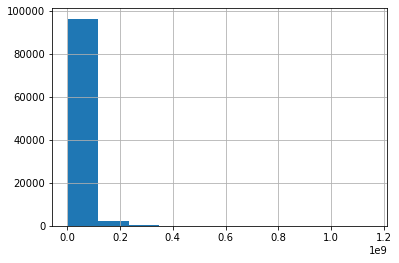

In [45]:
flats['price'].hist()

Посмотрим на логарифм цены.

<AxesSubplot:>

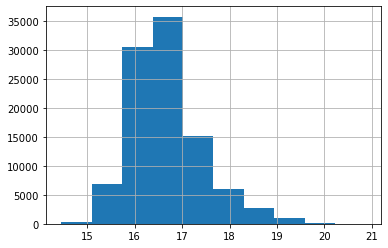

In [46]:
np.log1p(flats['price']).hist()

Посмотрим на максимальную и минимальную цены квартир. Самая недорогая стоит примерно 2 млн., самая дорогая - больше 1 млрд. Размах цен очень большой, но кажется, что такая стоимость квартир возможна и здесь нет ошибок.

In [47]:
flats['price'].max()

1155219000

In [48]:
flats['price'].min()

1900000

Посмотрим на box-plot для цен. Видим, что есть некоторое количество очень дорогих квартир. Но так как мы решили, что такие цены возможны, то удалять их из выборки не будем.

<Figure size 576x432 with 0 Axes>

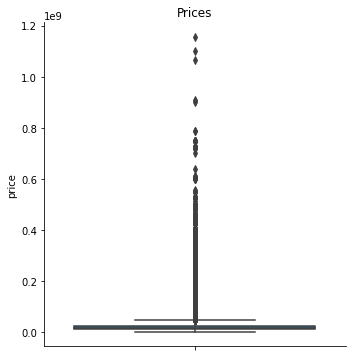

In [49]:
plt.figure(figsize=(8, 6))
sns.catplot(y='price', data=flats, kind="box") # box plot
plt.title('Prices')
plt.show()

Посмотрим на box-plot без самых дорогих квартир. Правый хвост все равно довольно большой.

<Figure size 576x432 with 0 Axes>

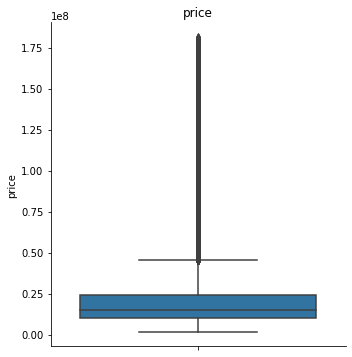

In [50]:
plt.figure(figsize=(8, 6))
sns.catplot(y='price', data=flats[flats['price'] <= flats['price'].quantile(0.99)], kind="box") # box plot
plt.title('price')
plt.show()

Посмотрим на box-plot для логарифма цены. Дальше мы будем прогнозировать именно логарифм цены, а потом перейдем с помощью преобразования обратно к цене.

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<Figure size 576x432 with 0 Axes>

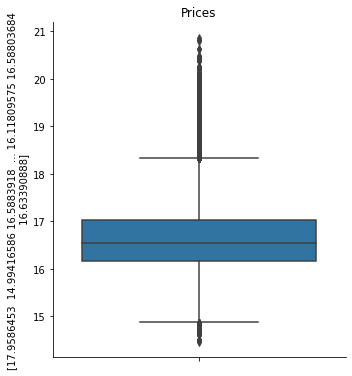

In [51]:
plt.figure(figsize=(8, 6))
sns.catplot(y=np.log1p(flats['price'].values), data=flats, kind="box") # box plot
plt.title('Prices')
plt.show()

В таблице нам даны тексты объявлений для квартир. Так как от нас дальше потребуется интерпретация полученных результатов, то будем работать с текстами только самыми простыми методами, основанными на подсчете слов и не будем пытаться применять векторизации текста, продвинутые языковые модели и т.д. Для дальнейшей работы с текстами необходимо их предварительно подготовить, приведя к одному регистру и удалив пунктуацию, цифры, эмоджи, стоп-слова, ссылки. Далее используем лемматизацию, которая позволит привести разные формы одного слова к некоторой единой, словарной форме (например (видели, видел, видеть) -> видеть).

In [53]:
def space_after_punctuation(text):
    text = text.replace('.', '. ').replace(',', ', ').replace('!', '! ').replace('?', '? ').replace(':', ': ')
    text = text.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ').replace('     ', ' ').replace('      ', ' ')
    return text
def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', punctuation))
    return text
def strip_emoji(text):
    return demoji.replace(text, '')

In [54]:
# Пример объявления, где используются эмоджи
flats.iloc[96737]['description']

'⚡️ Звоните и записывайтесь на просмотр своей студии уже сегодня! ⚡️\n\n\nПродаётся квартира-студия в Лосиноостровском районе.\nВысокий 1-й этаж. Застеклённая лоджия. Рамы деревянные, с защитными решётками.\nКвартира под ремонт.\n\n\nЧистый, красивый подъезд.\nДом после капитального ремонта.\n\n\nРазвитая инфраструктура, рядом есть всё, необходимое для комфортной жизни.\n\n\n\nТранспортная доступность до двух станций метро:\nМедведково и Бабушкинской автобусом 10 -15 минут,\nдо ж/д станций Лосиноостровская и Лось (будущие МДЦ-4) также 10 -15 минут.\nПешком до Медведково 20-25 минут, до ж/д станции Лось 18-20 минут.\n\n\nХороший спальный район, много зелени: три благоустроенных парка с зонами отдыха на берегах прудов, несколько скверов в округе и набережной реки Яузы.\nНет промышленных предприятий и мало мигрантов.\n\n\nМосковская прописка сразу после сделки в Росреестре.\n\nВозможна ипотека. Мат капитал не подходит.\n\nПрекрасный вариант для жизни и сдачи в аренду!\n\n\n\nЖдём Вас на п

In [55]:
%%time
flats['description'] = flats['description'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
flats['description'] = flats['description'].replace(r'\n\nhttp\S+', '', regex=True)
flats['description'] = flats['description'].replace(r'\n', '', regex=True).replace(r'\n\n', '', regex=True)
flats['description'] = flats['description'].replace(r'\r', '', regex=True).replace(r'\r\r', '', regex=True)
flats['description'] = flats['description'].astype(str).apply(space_after_punctuation)
flats['description'] = flats['description'].astype(str).apply(remove_punctuation)
flats['description'] = flats['description'].astype(str).apply(strip_emoji)
flats['description'] = flats['description'].apply(lambda x: x.strip().lower())

CPU times: total: 7min 23s
Wall time: 7min 28s


Если у квартиры в столбце description - пустая строка, то заменим ее на "Нет описания".

In [56]:
flats.loc[flats['description'] == '', 'description'] = 'Нет описания'

Далее удалим стоп-слова, лишние символы, цифры и т.д.

In [57]:
stopwords_ru = get_stop_words('russian')

In [58]:
delete_characters = ['№', '–', '»', '«', 'м²', '“', '”']

In [201]:
def prep_text(text):
    '''
    Принимает на вход текст. 
    Приводит его к нижнему регистру, производит лемматизацию слов, убирает стоп-слова, цифры, лишние символы.
    Возвращает обработанный текст (str).
    '''
    tokens = []
    m = Mystem()
    tok = m.lemmatize(str(text).lower())
    for i in tok:
        if i not in stopwords_ru  and i != ' ' and i.isalpha() and i.strip() not in delete_characters and len(i) > 1:
            tokens.append(i)
    return ' '.join(tokens)

In [61]:
%%time
norm_texts = []
index = 0
step = 10000
while index <= len(flats):
    norm_texts.extend(prep_text(' rzdltl '.join(flats['description'][index:index + step].to_list())).split(' rzdltl '))
    index += step

CPU times: total: 2min 48s
Wall time: 21min 26s


Осталось всего уникальных слов: 

In [62]:
len(set((' '.join(norm_texts)).split()))

56381

In [63]:
len(norm_texts) == len(flats)

True

Заменим исходные описания на предобработанные тексты.

In [64]:
flats['description'] = norm_texts

Посмотрим, какие слова чаще всего встречаются в описаниях квартир. Кажется, что такие слова как "школа", "метро", "парк", "инфраструктура", "ремонт" и другие должны влиять на стоимость квартиры, так как являются ее характеристиками или характеристиками района, в котором она находится.

In [65]:
c = collections.Counter()
for word in ' '.join(norm_texts).split():
    c[word] += 1

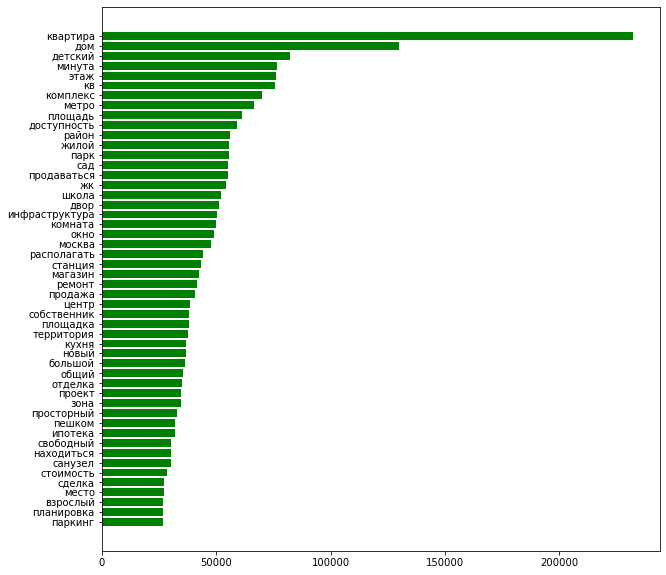

In [66]:
plt.figure(figsize=(10, 10))
plt.barh([c.most_common(50)[i][0] for i in range(50)][::-1], [c.most_common(50)[i][1] for i in range(50)][::-1], color = 'green')
plt.show()

Разделим выборку на обучение, валидацию и тест. На обучении модели будут обучаться, на валидации будем подбирать гиперпараметры, тестовую выборку используем в самом конце для итоговой проверки качества работы модели.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(flats.drop(columns=['price']), flats['price'], test_size = 0.3, shuffle=True,  random_state=42)

In [68]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle=True,  random_state=43)

Заполним оставшиеся пропуски в переменной rooms. Кажется, что количество комнат больше всего зависит от площади квартиры. Воспользуемся методом knn, чтобы найти самые похожие по площади квартиры. Будем смотреть на 50 самых похожих квартир. Классификатор обучим только на объектах из обучающей выборки.

In [69]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train.dropna(subset=['rooms'])[['total_square']], X_train['rooms'].dropna())

rooms_train = knn.predict(X_train[X_train['rooms'].isna()][['total_square']])
X_train.loc[X_train['rooms'].isna(), 'rooms'] = rooms_train

rooms_test = knn.predict(X_test[X_test['rooms'].isna()][['total_square']])
X_test.loc[X_test['rooms'].isna(), 'rooms'] = rooms_test

rooms_val = knn.predict(X_val[X_val['rooms'].isna()][['total_square']])
X_val.loc[X_val['rooms'].isna(), 'rooms'] = rooms_val

Видим, что пропусков в rooms больше не осталось.

In [70]:
X_train['rooms'].isna().any(), X_val['rooms'].isna().any(), X_test['rooms'].isna().any()

(False, False, False)

Видим, что пропусков в данных больше нет.

In [71]:
X_train.isna().any().any(), X_val.isna().any().any(), X_test.isna().any().any()

(False, False, False)

Добавим в качестве новой переменной отношение общей площади к количеству комнат. Так, небольшая квартира с большим количеством комнат или, наоборот, большая с маленьким количеством комнат, могут иметь какую-то нестандартную планировку, что может отражаться на цене.

In [72]:
X_train['total_square / rooms'] = X_train['total_square'] / X_train['rooms']
X_val['total_square / rooms'] = X_val['total_square'] / X_val['rooms']
X_test['total_square / rooms'] = X_test['total_square'] / X_test['rooms']

Тексты превратим в категориальные переменные с помощью tf-idf. Будем учитывать только те слова, которые встречаются 10 и больше раз, так как редкие слова кажутся не очень информативными.

In [73]:
def space_tokenizer(s):
    return s.split(' ')

In [74]:
tfidf_vec = TfidfVectorizer(tokenizer=space_tokenizer, min_df=10)
text_train = tfidf_vec.fit_transform(list(X_train['description']))
text_val = tfidf_vec.transform(list(X_val['description']))
text_test = tfidf_vec.transform(list(X_test['description']))

Будем использовать city, settlement, district, area, street, source, postcode в качестве категориальных переменных. Часто, когда работают с категориальными переменными, используют one-hot encoding, но так как из-за текстов у нас уже будет довольно много столбцов, попробуем другой подход, mean target encoding. Здесь каждой категории ставится среднее значение таргета + применяется регуляризация для того, чтобы избежать утечки информации из таргета в признак. Столбцы 'product_name', 'address_name', 'lat', 'lon', 'description', 'coords' удалим, так как мы уже достали из них всю нужную информацию

In [75]:
# Mean target encoding
enc = ce.target_encoder.TargetEncoder(cols=['city', 'settlement', 'district',
       'area', 'street', 'source', 'postcode'], min_samples_leaf=20, smoothing=10).fit(X_train, np.log1p(y_train.values))
X_train = enc.transform(X_train)
X_val = enc.transform(X_val)
X_test = enc.transform(X_test)
X_train = X_train.drop(columns=['product_name', 'address_name', 'lat', 'lon', 'description', 'coords'])
X_val = X_val.drop(columns=['product_name', 'address_name', 'lat', 'lon', 'description', 'coords'])
X_test = X_test.drop(columns=['product_name', 'address_name', 'lat', 'lon', 'description', 'coords'])

Объединим матрицу с текстовыми признаками с матрицей, содержащей информацию о квартирах.

In [76]:
X_train = sparse.hstack((sparse.csr_matrix(X_train), text_train))
X_val = sparse.hstack((sparse.csr_matrix(X_val), text_val))
X_test = sparse.hstack((sparse.csr_matrix(X_test), text_test))

Для прогнозирования будем использовать lightgbm. Как правило, этот лгоритм дает лучшее качество для задач регрессии, при этом он довольно быстрый (по крайней мере по сравнению с, например, случайным лесом и другими реализациями бустинга). Также бустинг не требует стандартизации признаков, устойчив к выбросам и нестандартным значениям признаков, для него не нужны монотонные преобразования признаков. Также нерелевантные признаки слабо влияют на итоговое качество модели.

In [272]:
# Эта ячейка считается несколько часов

dtrain = lgb.Dataset(X_train, label=np.log1p(y_train.values))
dval = lgb.Dataset(X_val, label=np.log1p(y_val.values))

params = {
    "objective": "mean_squared_error",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "num_boost_round": 2000
}

model = lgb.train(
    params,
    dtrain, 
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(50), log_evaluation(100)],
)

[I 2023-05-23 23:43:28,999] A new study created in memory with name: no-name-b1e3490e-2a24-43ce-9a9a-978d1ed4ffb9


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.128723	valid_1's rmse: 0.139466
[200]	valid_0's rmse: 0.114968	valid_1's rmse: 0.132142
[300]	valid_0's rmse: 0.107313	valid_1's rmse: 0.129509
[400]	valid_0's rmse: 0.101595	valid_1's rmse: 0.128177
[500]	valid_0's rmse: 0.0968516	valid_1's rmse: 0.127403
[600]	valid_0's rmse: 0.0928612	valid_1's rmse: 0.126767
[700]	valid_0's rmse: 0.0892944	valid_1's rmse: 0.126263
[800]	valid_0's rmse: 0.0860448	valid_1's rmse: 0.125891
[900]	valid_0's rmse: 0.0829567	valid_1's rmse: 0.12554
[1000]	valid_0's rmse: 0.0801747	valid_1's rmse: 0.125386
[1100]	valid_0's rmse: 0.0774864	valid_1's rmse: 0.125012
[1200]	valid_0's rmse: 0.0752257	valid_1's rmse: 0.124846
[1300]	valid_0's rmse: 0.0729198	valid_1's rmse: 0.124592
[1400]	valid_0's rmse: 0.0707906	valid_1's rmse: 0.124451
[1500]	valid_0's rmse: 0.0688222	valid_1's rmse: 0.124366
Early stopping, best iteration is:
[1469]	valid_0's rmse: 0.0694067	valid_1's rmse:



feature_fraction, val_score: 0.124335:   0%|          | 0/7 [03:19<?, ?it/s]

feature_fraction, val_score: 0.124335:  14%|#4        | 1/7 [03:19<19:57, 199.56s/it][I 2023-05-23 23:46:48,638] Trial 0 finished with value: 0.12433456156799384 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.12433456156799384.


feature_fraction, val_score: 0.124335:  14%|#4        | 1/7 [03:19<19:57, 199.56s/it]

[100]	valid_0's rmse: 0.127446	valid_1's rmse: 0.139518
[200]	valid_0's rmse: 0.113935	valid_1's rmse: 0.132681
[300]	valid_0's rmse: 0.106248	valid_1's rmse: 0.130369
[400]	valid_0's rmse: 0.100452	valid_1's rmse: 0.129004
[500]	valid_0's rmse: 0.0954953	valid_1's rmse: 0.128015
[600]	valid_0's rmse: 0.0913282	valid_1's rmse: 0.127459
[700]	valid_0's rmse: 0.0874863	valid_1's rmse: 0.126808
[800]	valid_0's rmse: 0.0840642	valid_1's rmse: 0.126394
[900]	valid_0's rmse: 0.0810835	valid_1's rmse: 0.126146
[1000]	valid_0's rmse: 0.0782796	valid_1's rmse: 0.12593
[1100]	valid_0's rmse: 0.0756928	valid_1's rmse: 0.125696
[1200]	valid_0's rmse: 0.0731209	valid_1's rmse: 0.125446
[1300]	valid_0's rmse: 0.0709809	valid_1's rmse: 0.125404
[1400]	valid_0's rmse: 0.0686878	valid_1's rmse: 0.125107
[1500]	valid_0's rmse: 0.0666463	valid_1's rmse: 0.124938
Early stopping, best iteration is:
[1469]	valid_0's rmse: 0.0694067	valid_1's rmse: 0.124335




feature_fraction, val_score: 0.124335:  14%|#4        | 1/7 [06:14<19:57, 199.56s/it]

feature_fraction, val_score: 0.124335:  29%|##8       | 2/7 [06:14<15:25, 185.01s/it][I 2023-05-23 23:49:43,470] Trial 1 finished with value: 0.12433456156799384 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.12433456156799384.


feature_fraction, val_score: 0.124335:  29%|##8       | 2/7 [06:14<15:25, 185.01s/it]

[100]	valid_0's rmse: 0.131433	valid_1's rmse: 0.141877
[200]	valid_0's rmse: 0.11669	valid_1's rmse: 0.133694
[300]	valid_0's rmse: 0.108449	valid_1's rmse: 0.130781
[400]	valid_0's rmse: 0.102575	valid_1's rmse: 0.129296
[500]	valid_0's rmse: 0.0978796	valid_1's rmse: 0.128497
[600]	valid_0's rmse: 0.0936467	valid_1's rmse: 0.127768
[700]	valid_0's rmse: 0.090062	valid_1's rmse: 0.127276
[800]	valid_0's rmse: 0.0866818	valid_1's rmse: 0.126868
[900]	valid_0's rmse: 0.0836196	valid_1's rmse: 0.126474
[1000]	valid_0's rmse: 0.0808399	valid_1's rmse: 0.12632
[1100]	valid_0's rmse: 0.0782613	valid_1's rmse: 0.125975
[1200]	valid_0's rmse: 0.0759292	valid_1's rmse: 0.125778
[1300]	valid_0's rmse: 0.073741	valid_1's rmse: 0.12561
[1400]	valid_0's rmse: 0.071633	valid_1's rmse: 0.125445
[1500]	valid_0's rmse: 0.0696441	valid_1's rmse: 0.125262
Early stopping, best iteration is:
[1469]	valid_0's rmse: 0.0694067	valid_1's rmse: 0.124335




feature_fraction, val_score: 0.124335:  29%|##8       | 2/7 [09:13<15:25, 185.01s/it]

feature_fraction, val_score: 0.124335:  43%|####2     | 3/7 [09:13<12:09, 182.45s/it][I 2023-05-23 23:52:42,861] Trial 2 finished with value: 0.12433456156799384 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.12433456156799384.


feature_fraction, val_score: 0.124335:  43%|####2     | 3/7 [09:13<12:09, 182.45s/it]

[100]	valid_0's rmse: 0.128809	valid_1's rmse: 0.139061
[200]	valid_0's rmse: 0.114838	valid_1's rmse: 0.13194
[300]	valid_0's rmse: 0.106965	valid_1's rmse: 0.129319
[400]	valid_0's rmse: 0.101066	valid_1's rmse: 0.127827
[500]	valid_0's rmse: 0.0962328	valid_1's rmse: 0.126716
[600]	valid_0's rmse: 0.0920736	valid_1's rmse: 0.126166
[700]	valid_0's rmse: 0.0884576	valid_1's rmse: 0.12564
[800]	valid_0's rmse: 0.0851509	valid_1's rmse: 0.125319
[900]	valid_0's rmse: 0.082101	valid_1's rmse: 0.124882
[1000]	valid_0's rmse: 0.0793719	valid_1's rmse: 0.124648
[1100]	valid_0's rmse: 0.0767806	valid_1's rmse: 0.124435
[1200]	valid_0's rmse: 0.0743396	valid_1's rmse: 0.124208
[1300]	valid_0's rmse: 0.0721384	valid_1's rmse: 0.124078
[1400]	valid_0's rmse: 0.0700862	valid_1's rmse: 0.123964
Early stopping, best iteration is:
[1423]	valid_0's rmse: 0.0695661	valid_1's rmse: 0.123922




feature_fraction, val_score: 0.123922:  43%|####2     | 3/7 [12:27<12:09, 182.45s/it]

feature_fraction, val_score: 0.123922:  57%|#####7    | 4/7 [12:27<09:21, 187.07s/it][I 2023-05-23 23:55:57,023] Trial 3 finished with value: 0.12392209409334777 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.12392209409334777.


feature_fraction, val_score: 0.123922:  57%|#####7    | 4/7 [12:28<09:21, 187.07s/it]

[100]	valid_0's rmse: 0.127888	valid_1's rmse: 0.139385
[200]	valid_0's rmse: 0.113993	valid_1's rmse: 0.132323
[300]	valid_0's rmse: 0.106323	valid_1's rmse: 0.129986
[400]	valid_0's rmse: 0.100569	valid_1's rmse: 0.128657
[500]	valid_0's rmse: 0.0957249	valid_1's rmse: 0.12775
[600]	valid_0's rmse: 0.0915466	valid_1's rmse: 0.126993
[700]	valid_0's rmse: 0.0878563	valid_1's rmse: 0.12653
[800]	valid_0's rmse: 0.0844597	valid_1's rmse: 0.126086
[900]	valid_0's rmse: 0.0812525	valid_1's rmse: 0.125613
[1000]	valid_0's rmse: 0.0784055	valid_1's rmse: 0.125204
[1100]	valid_0's rmse: 0.0757788	valid_1's rmse: 0.124907
[1200]	valid_0's rmse: 0.0732343	valid_1's rmse: 0.124621
[1300]	valid_0's rmse: 0.0709262	valid_1's rmse: 0.124404
[1400]	valid_0's rmse: 0.0688841	valid_1's rmse: 0.124326
Early stopping, best iteration is:
[1423]	valid_0's rmse: 0.0695661	valid_1's rmse: 0.123922




feature_fraction, val_score: 0.123922:  57%|#####7    | 4/7 [15:20<09:21, 187.07s/it]

feature_fraction, val_score: 0.123922:  71%|#######1  | 5/7 [15:20<06:03, 181.86s/it][I 2023-05-23 23:58:49,624] Trial 4 finished with value: 0.12392209409334777 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.12392209409334777.


feature_fraction, val_score: 0.123922:  71%|#######1  | 5/7 [15:20<06:03, 181.86s/it]

[100]	valid_0's rmse: 0.128642	valid_1's rmse: 0.139555
[200]	valid_0's rmse: 0.114628	valid_1's rmse: 0.132346
[300]	valid_0's rmse: 0.106804	valid_1's rmse: 0.130121
[400]	valid_0's rmse: 0.101216	valid_1's rmse: 0.128922
[500]	valid_0's rmse: 0.096317	valid_1's rmse: 0.127987
[600]	valid_0's rmse: 0.0920341	valid_1's rmse: 0.127263
[700]	valid_0's rmse: 0.0883331	valid_1's rmse: 0.126636
[800]	valid_0's rmse: 0.0849317	valid_1's rmse: 0.126267
[900]	valid_0's rmse: 0.0818319	valid_1's rmse: 0.125964
[1000]	valid_0's rmse: 0.0790411	valid_1's rmse: 0.125686
[1100]	valid_0's rmse: 0.0764126	valid_1's rmse: 0.125409
[1200]	valid_0's rmse: 0.0740992	valid_1's rmse: 0.125214
[1300]	valid_0's rmse: 0.0718547	valid_1's rmse: 0.125025
[1400]	valid_0's rmse: 0.069768	valid_1's rmse: 0.124878
Early stopping, best iteration is:
[1423]	valid_0's rmse: 0.0695661	valid_1's rmse: 0.123922




feature_fraction, val_score: 0.123922:  71%|#######1  | 5/7 [18:07<06:03, 181.86s/it]

feature_fraction, val_score: 0.123922:  86%|########5 | 6/7 [18:07<02:56, 176.72s/it][I 2023-05-24 00:01:36,361] Trial 5 finished with value: 0.12392209409334777 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.12392209409334777.


feature_fraction, val_score: 0.123922:  86%|########5 | 6/7 [18:07<02:56, 176.72s/it]

[100]	valid_0's rmse: 0.127803	valid_1's rmse: 0.140169
[200]	valid_0's rmse: 0.114129	valid_1's rmse: 0.133102
[300]	valid_0's rmse: 0.106362	valid_1's rmse: 0.130604
[400]	valid_0's rmse: 0.100568	valid_1's rmse: 0.129405
[500]	valid_0's rmse: 0.0955424	valid_1's rmse: 0.12833
[600]	valid_0's rmse: 0.0912041	valid_1's rmse: 0.127506
[700]	valid_0's rmse: 0.0874198	valid_1's rmse: 0.127078
[800]	valid_0's rmse: 0.0839481	valid_1's rmse: 0.126517
[900]	valid_0's rmse: 0.0807435	valid_1's rmse: 0.126052
[1000]	valid_0's rmse: 0.0778768	valid_1's rmse: 0.125771
[1100]	valid_0's rmse: 0.0751977	valid_1's rmse: 0.12555
[1200]	valid_0's rmse: 0.0727457	valid_1's rmse: 0.125358
[1300]	valid_0's rmse: 0.0704037	valid_1's rmse: 0.125128
[1400]	valid_0's rmse: 0.0682247	valid_1's rmse: 0.124978
Early stopping, best iteration is:
[1423]	valid_0's rmse: 0.0695661	valid_1's rmse: 0.123922




feature_fraction, val_score: 0.123922:  86%|########5 | 6/7 [21:10<02:56, 176.72s/it]

feature_fraction, val_score: 0.123922: 100%|##########| 7/7 [21:10<00:00, 181.51s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.123922:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.111125	valid_1's rmse: 0.131886
[200]	valid_0's rmse: 0.0950863	valid_1's rmse: 0.12732
[300]	valid_0's rmse: 0.0855961	valid_1's rmse: 0.125574
[400]	valid_0's rmse: 0.0785264	valid_1's rmse: 0.124909
[500]	valid_0's rmse: 0.0725957	valid_1's rmse: 0.124451
[600]	valid_0's rmse: 0.0675445	valid_1's rmse: 0.123967
[700]	valid_0's rmse: 0.0632416	valid_1's rmse: 0.123671
[800]	valid_0's rmse: 0.0592127	valid_1's rmse: 0.123408
[900]	valid_0's rmse: 0.0556649	valid_1's rmse: 0.123175
Early stopping, best iteration is:
[895]	valid_0's rmse: 0.0558229	valid_1's rmse: 0.123169




num_leaves, val_score: 0.123169:   0%|          | 0/20 [02:56<?, ?it/s]

num_leaves, val_score: 0.123169:   5%|5         | 1/20 [02:56<56:01, 176.93s/it][I 2023-05-24 00:07:36,585] Trial 7 finished with value: 0.12316894497558292 and parameters: {'num_leaves': 69}. Best is trial 7 with value: 0.12316894497558292.


num_leaves, val_score: 0.123169:   5%|5         | 1/20 [02:56<56:01, 176.93s/it]

[100]	valid_0's rmse: 0.10694	valid_1's rmse: 0.130239
[200]	valid_0's rmse: 0.0901922	valid_1's rmse: 0.125983
[300]	valid_0's rmse: 0.0800988	valid_1's rmse: 0.124771
[400]	valid_0's rmse: 0.0728315	valid_1's rmse: 0.124144
[500]	valid_0's rmse: 0.0667697	valid_1's rmse: 0.123684
[600]	valid_0's rmse: 0.0616537	valid_1's rmse: 0.123246
[700]	valid_0's rmse: 0.0572123	valid_1's rmse: 0.123023
[800]	valid_0's rmse: 0.0533336	valid_1's rmse: 0.122796
[900]	valid_0's rmse: 0.0497553	valid_1's rmse: 0.122583
[1000]	valid_0's rmse: 0.0465468	valid_1's rmse: 0.122402
[1100]	valid_0's rmse: 0.043883	valid_1's rmse: 0.122231
[1200]	valid_0's rmse: 0.0415114	valid_1's rmse: 0.122133
[1300]	valid_0's rmse: 0.0394964	valid_1's rmse: 0.122088
Early stopping, best iteration is:
[1273]	valid_0's rmse: 0.0399988	valid_1's rmse: 0.12207




num_leaves, val_score: 0.122070:   5%|5         | 1/20 [07:38<56:01, 176.93s/it]

num_leaves, val_score: 0.122070:  10%|#         | 2/20 [07:38<1:11:35, 238.63s/it][I 2023-05-24 00:12:18,427] Trial 8 finished with value: 0.12207007881881297 and parameters: {'num_leaves': 82}. Best is trial 8 with value: 0.12207007881881297.


num_leaves, val_score: 0.122070:  10%|#         | 2/20 [07:38<1:11:35, 238.63s/it]

[100]	valid_0's rmse: 0.108966	valid_1's rmse: 0.130578
[200]	valid_0's rmse: 0.0926417	valid_1's rmse: 0.125984
[300]	valid_0's rmse: 0.0830088	valid_1's rmse: 0.124571
[400]	valid_0's rmse: 0.075729	valid_1's rmse: 0.123781
[500]	valid_0's rmse: 0.0696779	valid_1's rmse: 0.123261
[600]	valid_0's rmse: 0.064502	valid_1's rmse: 0.122918
[700]	valid_0's rmse: 0.0600906	valid_1's rmse: 0.122645
[800]	valid_0's rmse: 0.0562819	valid_1's rmse: 0.12251
[900]	valid_0's rmse: 0.053064	valid_1's rmse: 0.122391
[1000]	valid_0's rmse: 0.0498497	valid_1's rmse: 0.122186
[1100]	valid_0's rmse: 0.047169	valid_1's rmse: 0.12211
[1200]	valid_0's rmse: 0.0446528	valid_1's rmse: 0.121984
[1300]	valid_0's rmse: 0.0424218	valid_1's rmse: 0.121896
Early stopping, best iteration is:
[1323]	valid_0's rmse: 0.0390269	valid_1's rmse: 0.122085




num_leaves, val_score: 0.122070:  10%|#         | 2/20 [12:03<1:11:35, 238.63s/it]

num_leaves, val_score: 0.122070:  15%|#5        | 3/20 [12:03<1:10:58, 250.53s/it][I 2023-05-24 00:16:43,098] Trial 9 finished with value: 0.12208499565117935 and parameters: {'num_leaves': 75}. Best is trial 8 with value: 0.12207007881881297.


num_leaves, val_score: 0.122070:  15%|#5        | 3/20 [12:03<1:10:58, 250.53s/it]

[100]	valid_0's rmse: 0.104316	valid_1's rmse: 0.129191
[200]	valid_0's rmse: 0.0868331	valid_1's rmse: 0.124957
[300]	valid_0's rmse: 0.0768439	valid_1's rmse: 0.123481
[400]	valid_0's rmse: 0.0694159	valid_1's rmse: 0.122762
[500]	valid_0's rmse: 0.0632771	valid_1's rmse: 0.122307
[600]	valid_0's rmse: 0.057953	valid_1's rmse: 0.121871
[700]	valid_0's rmse: 0.0536086	valid_1's rmse: 0.121607
[800]	valid_0's rmse: 0.0497523	valid_1's rmse: 0.12136
[900]	valid_0's rmse: 0.046534	valid_1's rmse: 0.12128
[1000]	valid_0's rmse: 0.0435246	valid_1's rmse: 0.121141
[1100]	valid_0's rmse: 0.0407873	valid_1's rmse: 0.120913
[1200]	valid_0's rmse: 0.0384585	valid_1's rmse: 0.120823
[1300]	valid_0's rmse: 0.0364713	valid_1's rmse: 0.120789
[1400]	valid_0's rmse: 0.0346142	valid_1's rmse: 0.1207
[1500]	valid_0's rmse: 0.0329276	valid_1's rmse: 0.120591
[1600]	valid_0's rmse: 0.0313892	valid_1's rmse: 0.120508
[1700]	valid_0's rmse: 0.030011	valid_1's rmse: 0.120474
Early stopping, best iteration 



num_leaves, val_score: 0.120460:  15%|#5        | 3/20 [19:02<1:10:58, 250.53s/it]

num_leaves, val_score: 0.120460:  20%|##        | 4/20 [19:02<1:24:35, 317.21s/it][I 2023-05-24 00:23:42,511] Trial 10 finished with value: 0.12045992144987455 and parameters: {'num_leaves': 91}. Best is trial 10 with value: 0.12045992144987455.


num_leaves, val_score: 0.120460:  20%|##        | 4/20 [19:02<1:24:35, 317.21s/it]

[100]	valid_0's rmse: 0.0904646	valid_1's rmse: 0.126201
[200]	valid_0's rmse: 0.0710834	valid_1's rmse: 0.123129
[300]	valid_0's rmse: 0.0599014	valid_1's rmse: 0.122123
[400]	valid_0's rmse: 0.0519055	valid_1's rmse: 0.121658
[500]	valid_0's rmse: 0.0457855	valid_1's rmse: 0.121352
[600]	valid_0's rmse: 0.0409705	valid_1's rmse: 0.121056
[700]	valid_0's rmse: 0.0368554	valid_1's rmse: 0.120886
[800]	valid_0's rmse: 0.0336343	valid_1's rmse: 0.120781
[900]	valid_0's rmse: 0.0308482	valid_1's rmse: 0.120712
[1000]	valid_0's rmse: 0.0284847	valid_1's rmse: 0.12059
[1100]	valid_0's rmse: 0.0264861	valid_1's rmse: 0.12051
[1200]	valid_0's rmse: 0.0248341	valid_1's rmse: 0.120446
[1300]	valid_0's rmse: 0.0233106	valid_1's rmse: 0.120366
[1400]	valid_0's rmse: 0.0220889	valid_1's rmse: 0.120331
[1500]	valid_0's rmse: 0.0209766	valid_1's rmse: 0.120284
Early stopping, best iteration is:
[1530]	valid_0's rmse: 0.0206704	valid_1's rmse: 0.12028




num_leaves, val_score: 0.120280:  20%|##        | 4/20 [28:08<1:24:35, 317.21s/it]

num_leaves, val_score: 0.120280:  25%|##5       | 5/20 [28:08<1:39:52, 399.53s/it][I 2023-05-24 00:32:48,002] Trial 11 finished with value: 0.12027990049989712 and parameters: {'num_leaves': 154}. Best is trial 11 with value: 0.12027990049989712.


num_leaves, val_score: 0.120280:  25%|##5       | 5/20 [28:08<1:39:52, 399.53s/it]

[100]	valid_0's rmse: 0.101836	valid_1's rmse: 0.128728
[200]	valid_0's rmse: 0.0838935	valid_1's rmse: 0.124661
[300]	valid_0's rmse: 0.0734548	valid_1's rmse: 0.123346
[400]	valid_0's rmse: 0.0659015	valid_1's rmse: 0.122653
[500]	valid_0's rmse: 0.0597344	valid_1's rmse: 0.122232
[600]	valid_0's rmse: 0.0545908	valid_1's rmse: 0.121842
[700]	valid_0's rmse: 0.0500335	valid_1's rmse: 0.121608
[800]	valid_0's rmse: 0.0463113	valid_1's rmse: 0.121474
[900]	valid_0's rmse: 0.0430061	valid_1's rmse: 0.121283
[1000]	valid_0's rmse: 0.0402519	valid_1's rmse: 0.121195
[1100]	valid_0's rmse: 0.0377424	valid_1's rmse: 0.121031
[1200]	valid_0's rmse: 0.035479	valid_1's rmse: 0.120917
[1300]	valid_0's rmse: 0.0335015	valid_1's rmse: 0.120825
[1400]	valid_0's rmse: 0.0318513	valid_1's rmse: 0.120775
[1500]	valid_0's rmse: 0.0302388	valid_1's rmse: 0.120677
Early stopping, best iteration is:
[1530]	valid_0's rmse: 0.0206704	valid_1's rmse: 0.12028




num_leaves, val_score: 0.120280:  25%|##5       | 5/20 [34:30<1:39:52, 399.53s/it]

num_leaves, val_score: 0.120280:  30%|###       | 6/20 [34:30<1:31:52, 393.75s/it][I 2023-05-24 00:39:10,546] Trial 12 finished with value: 0.12027990049989712 and parameters: {'num_leaves': 101}. Best is trial 11 with value: 0.12027990049989712.


num_leaves, val_score: 0.120280:  30%|###       | 6/20 [34:30<1:31:52, 393.75s/it]

[100]	valid_0's rmse: 0.0812154	valid_1's rmse: 0.124748
[200]	valid_0's rmse: 0.0604352	valid_1's rmse: 0.122275
[300]	valid_0's rmse: 0.0489673	valid_1's rmse: 0.121363
[400]	valid_0's rmse: 0.0412718	valid_1's rmse: 0.120922
[500]	valid_0's rmse: 0.0355501	valid_1's rmse: 0.120545
[600]	valid_0's rmse: 0.0312003	valid_1's rmse: 0.120327
[700]	valid_0's rmse: 0.027837	valid_1's rmse: 0.120184
[800]	valid_0's rmse: 0.0251242	valid_1's rmse: 0.120087
[900]	valid_0's rmse: 0.0230176	valid_1's rmse: 0.119975
[1000]	valid_0's rmse: 0.0212695	valid_1's rmse: 0.119867
[1100]	valid_0's rmse: 0.0197354	valid_1's rmse: 0.119789
[1200]	valid_0's rmse: 0.0185616	valid_1's rmse: 0.119762
[1300]	valid_0's rmse: 0.0174842	valid_1's rmse: 0.119722
[1400]	valid_0's rmse: 0.0165901	valid_1's rmse: 0.119695
[1500]	valid_0's rmse: 0.0157075	valid_1's rmse: 0.119658
[1600]	valid_0's rmse: 0.0149767	valid_1's rmse: 0.119626
[1700]	valid_0's rmse: 0.0143172	valid_1's rmse: 0.119609
[1800]	valid_0's rmse: 0



num_leaves, val_score: 0.119563:  30%|###       | 6/20 [45:53<1:31:52, 393.75s/it]

num_leaves, val_score: 0.119563:  35%|###5      | 7/20 [45:53<1:45:46, 488.19s/it][I 2023-05-24 00:50:33,159] Trial 13 finished with value: 0.11956294298407469 and parameters: {'num_leaves': 215}. Best is trial 13 with value: 0.11956294298407469.


num_leaves, val_score: 0.119563:  35%|###5      | 7/20 [45:53<1:45:46, 488.19s/it]

[100]	valid_0's rmse: 0.121766	valid_1's rmse: 0.135281
[200]	valid_0's rmse: 0.107109	valid_1's rmse: 0.129283
[300]	valid_0's rmse: 0.098713	valid_1's rmse: 0.127156
[400]	valid_0's rmse: 0.0924668	valid_1's rmse: 0.126014
[500]	valid_0's rmse: 0.0870277	valid_1's rmse: 0.125138
[600]	valid_0's rmse: 0.0825774	valid_1's rmse: 0.12456
[700]	valid_0's rmse: 0.078836	valid_1's rmse: 0.124274
[800]	valid_0's rmse: 0.0753576	valid_1's rmse: 0.123933
[900]	valid_0's rmse: 0.0721443	valid_1's rmse: 0.123654
[1000]	valid_0's rmse: 0.0690395	valid_1's rmse: 0.123409
[1100]	valid_0's rmse: 0.0663011	valid_1's rmse: 0.123231
[1200]	valid_0's rmse: 0.0637584	valid_1's rmse: 0.123068
[1300]	valid_0's rmse: 0.0613801	valid_1's rmse: 0.122956
[1400]	valid_0's rmse: 0.0590841	valid_1's rmse: 0.122761
[1500]	valid_0's rmse: 0.0570792	valid_1's rmse: 0.122682
[1600]	valid_0's rmse: 0.0551422	valid_1's rmse: 0.122578
[1700]	valid_0's rmse: 0.0534159	valid_1's rmse: 0.122496
[1800]	valid_0's rmse: 0.051



num_leaves, val_score: 0.119563:  35%|###5      | 7/20 [50:30<1:45:46, 488.19s/it]

num_leaves, val_score: 0.119563:  40%|####      | 8/20 [50:30<1:24:13, 421.10s/it][I 2023-05-24 00:55:10,609] Trial 14 finished with value: 0.11956294298407469 and parameters: {'num_leaves': 43}. Best is trial 13 with value: 0.11956294298407469.


num_leaves, val_score: 0.119563:  40%|####      | 8/20 [50:31<1:24:13, 421.10s/it]

[100]	valid_0's rmse: 0.120129	valid_1's rmse: 0.134609
[200]	valid_0's rmse: 0.105327	valid_1's rmse: 0.128718
[300]	valid_0's rmse: 0.0968058	valid_1's rmse: 0.126714
[400]	valid_0's rmse: 0.0902476	valid_1's rmse: 0.125554
[500]	valid_0's rmse: 0.0848061	valid_1's rmse: 0.124949
[600]	valid_0's rmse: 0.0802493	valid_1's rmse: 0.12445
[700]	valid_0's rmse: 0.0762551	valid_1's rmse: 0.124093
[800]	valid_0's rmse: 0.0727373	valid_1's rmse: 0.123796
[900]	valid_0's rmse: 0.0695112	valid_1's rmse: 0.123624
[1000]	valid_0's rmse: 0.066409	valid_1's rmse: 0.123389
[1100]	valid_0's rmse: 0.063647	valid_1's rmse: 0.123268
[1200]	valid_0's rmse: 0.0611814	valid_1's rmse: 0.123184
[1300]	valid_0's rmse: 0.0588083	valid_1's rmse: 0.123081
[1400]	valid_0's rmse: 0.0566214	valid_1's rmse: 0.122933
[1500]	valid_0's rmse: 0.0545555	valid_1's rmse: 0.122779
[1600]	valid_0's rmse: 0.0526884	valid_1's rmse: 0.122682
[1700]	valid_0's rmse: 0.050862	valid_1's rmse: 0.122663
[1800]	valid_0's rmse: 0.0492



num_leaves, val_score: 0.119563:  40%|####      | 8/20 [55:19<1:24:13, 421.10s/it]

num_leaves, val_score: 0.119563:  45%|####5     | 9/20 [55:19<1:09:35, 379.56s/it][I 2023-05-24 00:59:58,830] Trial 15 finished with value: 0.11956294298407469 and parameters: {'num_leaves': 46}. Best is trial 13 with value: 0.11956294298407469.


num_leaves, val_score: 0.119563:  45%|####5     | 9/20 [55:19<1:09:35, 379.56s/it]

[100]	valid_0's rmse: 0.114827	valid_1's rmse: 0.132678
[200]	valid_0's rmse: 0.0992254	valid_1's rmse: 0.127401
[300]	valid_0's rmse: 0.0900979	valid_1's rmse: 0.125826
[400]	valid_0's rmse: 0.0832841	valid_1's rmse: 0.124983
[500]	valid_0's rmse: 0.0774623	valid_1's rmse: 0.124378
[600]	valid_0's rmse: 0.0725644	valid_1's rmse: 0.12396
[700]	valid_0's rmse: 0.0684051	valid_1's rmse: 0.123619
[800]	valid_0's rmse: 0.064538	valid_1's rmse: 0.123453
[900]	valid_0's rmse: 0.0612401	valid_1's rmse: 0.123251
[1000]	valid_0's rmse: 0.0581715	valid_1's rmse: 0.123152
[1100]	valid_0's rmse: 0.0554227	valid_1's rmse: 0.122948
[1200]	valid_0's rmse: 0.0529632	valid_1's rmse: 0.122828
[1300]	valid_0's rmse: 0.0505881	valid_1's rmse: 0.122768
[1400]	valid_0's rmse: 0.0484521	valid_1's rmse: 0.122713
[1500]	valid_0's rmse: 0.0464721	valid_1's rmse: 0.122592
[1600]	valid_0's rmse: 0.0446299	valid_1's rmse: 0.122548
[1700]	valid_0's rmse: 0.0429144	valid_1's rmse: 0.12245
[1800]	valid_0's rmse: 0.04



num_leaves, val_score: 0.119563:  45%|####5     | 9/20 [1:00:46<1:09:35, 379.56s/it]

num_leaves, val_score: 0.119563:  50%|#####     | 10/20 [1:00:46<1:00:34, 363.46s/it][I 2023-05-24 01:05:26,249] Trial 16 finished with value: 0.11956294298407469 and parameters: {'num_leaves': 59}. Best is trial 13 with value: 0.11956294298407469.


num_leaves, val_score: 0.119563:  50%|#####     | 10/20 [1:00:46<1:00:34, 363.46s/it]

[100]	valid_0's rmse: 0.0779447	valid_1's rmse: 0.124104
[200]	valid_0's rmse: 0.0570437	valid_1's rmse: 0.121607
[300]	valid_0's rmse: 0.0456301	valid_1's rmse: 0.120708
[400]	valid_0's rmse: 0.038053	valid_1's rmse: 0.120313
[500]	valid_0's rmse: 0.0327312	valid_1's rmse: 0.120085
[600]	valid_0's rmse: 0.028705	valid_1's rmse: 0.11981
[700]	valid_0's rmse: 0.0255783	valid_1's rmse: 0.119666
[800]	valid_0's rmse: 0.0231812	valid_1's rmse: 0.119506
[900]	valid_0's rmse: 0.0211558	valid_1's rmse: 0.119384
[1000]	valid_0's rmse: 0.0195597	valid_1's rmse: 0.119337
[1100]	valid_0's rmse: 0.0181971	valid_1's rmse: 0.119281
[1200]	valid_0's rmse: 0.0170934	valid_1's rmse: 0.119218
[1300]	valid_0's rmse: 0.016099	valid_1's rmse: 0.119182
[1400]	valid_0's rmse: 0.015255	valid_1's rmse: 0.119124
[1500]	valid_0's rmse: 0.0145491	valid_1's rmse: 0.119094
[1600]	valid_0's rmse: 0.0138688	valid_1's rmse: 0.119073
[1700]	valid_0's rmse: 0.0132646	valid_1's rmse: 0.119057
[1800]	valid_0's rmse: 0.012



num_leaves, val_score: 0.119024:  50%|#####     | 10/20 [1:13:13<1:00:34, 363.46s/it]

num_leaves, val_score: 0.119024:  55%|#####5    | 11/20 [1:13:13<1:12:07, 480.82s/it][I 2023-05-24 01:17:53,154] Trial 17 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 240}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  55%|#####5    | 11/20 [1:13:13<1:12:07, 480.82s/it]

[100]	valid_0's rmse: 0.0765794	valid_1's rmse: 0.123626
[200]	valid_0's rmse: 0.0556396	valid_1's rmse: 0.12123
[300]	valid_0's rmse: 0.0440574	valid_1's rmse: 0.120604
[400]	valid_0's rmse: 0.0368914	valid_1's rmse: 0.120232
[500]	valid_0's rmse: 0.0313907	valid_1's rmse: 0.119899
[600]	valid_0's rmse: 0.0275223	valid_1's rmse: 0.119729
[700]	valid_0's rmse: 0.0245541	valid_1's rmse: 0.119557
[800]	valid_0's rmse: 0.0221346	valid_1's rmse: 0.119453
[900]	valid_0's rmse: 0.0201995	valid_1's rmse: 0.119363
[1000]	valid_0's rmse: 0.0185887	valid_1's rmse: 0.11931
[1100]	valid_0's rmse: 0.0173389	valid_1's rmse: 0.119265
[1200]	valid_0's rmse: 0.0163206	valid_1's rmse: 0.119223
[1300]	valid_0's rmse: 0.0153771	valid_1's rmse: 0.119184
[1400]	valid_0's rmse: 0.0146104	valid_1's rmse: 0.119166
[1500]	valid_0's rmse: 0.013857	valid_1's rmse: 0.119151
[1600]	valid_0's rmse: 0.0132379	valid_1's rmse: 0.119133
[1700]	valid_0's rmse: 0.0126991	valid_1's rmse: 0.119123
[1800]	valid_0's rmse: 0.0



num_leaves, val_score: 0.119024:  55%|#####5    | 11/20 [1:26:15<1:12:07, 480.82s/it]

num_leaves, val_score: 0.119024:  60%|######    | 12/20 [1:26:15<1:16:20, 572.51s/it][I 2023-05-24 01:30:55,382] Trial 18 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 250}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  60%|######    | 12/20 [1:26:15<1:16:20, 572.51s/it]

[100]	valid_0's rmse: 0.0767017	valid_1's rmse: 0.12431
[200]	valid_0's rmse: 0.0557572	valid_1's rmse: 0.121857
[300]	valid_0's rmse: 0.0444112	valid_1's rmse: 0.121091
[400]	valid_0's rmse: 0.0367803	valid_1's rmse: 0.120685
[500]	valid_0's rmse: 0.0314375	valid_1's rmse: 0.120456
[600]	valid_0's rmse: 0.0275057	valid_1's rmse: 0.120228
[700]	valid_0's rmse: 0.0245022	valid_1's rmse: 0.120058
[800]	valid_0's rmse: 0.022163	valid_1's rmse: 0.119943
[900]	valid_0's rmse: 0.0203206	valid_1's rmse: 0.119852
[1000]	valid_0's rmse: 0.0187621	valid_1's rmse: 0.119784
[1100]	valid_0's rmse: 0.0174716	valid_1's rmse: 0.119721
[1200]	valid_0's rmse: 0.016403	valid_1's rmse: 0.119668
[1300]	valid_0's rmse: 0.0154456	valid_1's rmse: 0.119635
[1400]	valid_0's rmse: 0.0146302	valid_1's rmse: 0.119608
[1500]	valid_0's rmse: 0.0139613	valid_1's rmse: 0.119574
[1600]	valid_0's rmse: 0.0132649	valid_1's rmse: 0.119555
[1700]	valid_0's rmse: 0.0127809	valid_1's rmse: 0.119539
[1800]	valid_0's rmse: 0.0



num_leaves, val_score: 0.119024:  60%|######    | 12/20 [1:38:57<1:16:20, 572.51s/it]

num_leaves, val_score: 0.119024:  65%|######5   | 13/20 [1:38:57<1:13:29, 629.98s/it][I 2023-05-24 01:43:37,593] Trial 19 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 249}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  65%|######5   | 13/20 [1:38:57<1:13:29, 629.98s/it]

[100]	valid_0's rmse: 0.0849242	valid_1's rmse: 0.125153
[200]	valid_0's rmse: 0.0644755	valid_1's rmse: 0.122322
[300]	valid_0's rmse: 0.0531834	valid_1's rmse: 0.121517
[400]	valid_0's rmse: 0.0452434	valid_1's rmse: 0.121008
[500]	valid_0's rmse: 0.039226	valid_1's rmse: 0.120765
[600]	valid_0's rmse: 0.0346028	valid_1's rmse: 0.120571
[700]	valid_0's rmse: 0.0308912	valid_1's rmse: 0.120396
[800]	valid_0's rmse: 0.0279523	valid_1's rmse: 0.12025
[900]	valid_0's rmse: 0.0255957	valid_1's rmse: 0.120149
[1000]	valid_0's rmse: 0.0236559	valid_1's rmse: 0.120075
[1100]	valid_0's rmse: 0.0220139	valid_1's rmse: 0.12001
[1200]	valid_0's rmse: 0.020624	valid_1's rmse: 0.119962
[1300]	valid_0's rmse: 0.0193885	valid_1's rmse: 0.119911
[1400]	valid_0's rmse: 0.0182997	valid_1's rmse: 0.119837
[1500]	valid_0's rmse: 0.0174593	valid_1's rmse: 0.119806
[1600]	valid_0's rmse: 0.0166432	valid_1's rmse: 0.119785
[1700]	valid_0's rmse: 0.0159289	valid_1's rmse: 0.119765
[1800]	valid_0's rmse: 0.01



num_leaves, val_score: 0.119024:  65%|######5   | 13/20 [1:48:41<1:13:29, 629.98s/it]

num_leaves, val_score: 0.119024:  70%|#######   | 14/20 [1:48:41<1:01:36, 616.10s/it][I 2023-05-24 01:53:21,627] Trial 20 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 189}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  70%|#######   | 14/20 [1:48:42<1:01:36, 616.10s/it]

[100]	valid_0's rmse: 0.0768802	valid_1's rmse: 0.123838
[200]	valid_0's rmse: 0.0560031	valid_1's rmse: 0.121489
[300]	valid_0's rmse: 0.044601	valid_1's rmse: 0.12075
[400]	valid_0's rmse: 0.0372692	valid_1's rmse: 0.120495
[500]	valid_0's rmse: 0.0318528	valid_1's rmse: 0.120206
[600]	valid_0's rmse: 0.0277432	valid_1's rmse: 0.119971
[700]	valid_0's rmse: 0.0245306	valid_1's rmse: 0.119832
[800]	valid_0's rmse: 0.0221402	valid_1's rmse: 0.11972
[900]	valid_0's rmse: 0.0202647	valid_1's rmse: 0.119647
[1000]	valid_0's rmse: 0.0187287	valid_1's rmse: 0.119605
[1100]	valid_0's rmse: 0.017339	valid_1's rmse: 0.119578
[1200]	valid_0's rmse: 0.0162519	valid_1's rmse: 0.119524
[1300]	valid_0's rmse: 0.0153708	valid_1's rmse: 0.119472
[1400]	valid_0's rmse: 0.0146306	valid_1's rmse: 0.119442
[1500]	valid_0's rmse: 0.0139488	valid_1's rmse: 0.11943
[1600]	valid_0's rmse: 0.0133471	valid_1's rmse: 0.119403
[1700]	valid_0's rmse: 0.0128074	valid_1's rmse: 0.119386
[1800]	valid_0's rmse: 0.012



num_leaves, val_score: 0.119024:  70%|#######   | 14/20 [2:00:39<1:01:36, 616.10s/it]

num_leaves, val_score: 0.119024:  75%|#######5  | 15/20 [2:00:39<53:53, 646.63s/it]  [I 2023-05-24 02:05:18,987] Trial 21 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 248}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  75%|#######5  | 15/20 [2:00:39<53:53, 646.63s/it]

[100]	valid_0's rmse: 0.155649	valid_1's rmse: 0.158061
[200]	valid_0's rmse: 0.143741	valid_1's rmse: 0.148055
[300]	valid_0's rmse: 0.137506	valid_1's rmse: 0.143609
[400]	valid_0's rmse: 0.132669	valid_1's rmse: 0.140436
[500]	valid_0's rmse: 0.129078	valid_1's rmse: 0.13832
[600]	valid_0's rmse: 0.126161	valid_1's rmse: 0.136885
[700]	valid_0's rmse: 0.123565	valid_1's rmse: 0.135627
[800]	valid_0's rmse: 0.121156	valid_1's rmse: 0.134525
[900]	valid_0's rmse: 0.119311	valid_1's rmse: 0.133838
[1000]	valid_0's rmse: 0.117508	valid_1's rmse: 0.133292
[1100]	valid_0's rmse: 0.115736	valid_1's rmse: 0.132563
[1200]	valid_0's rmse: 0.114245	valid_1's rmse: 0.132272
[1300]	valid_0's rmse: 0.112699	valid_1's rmse: 0.131762
[1400]	valid_0's rmse: 0.111471	valid_1's rmse: 0.131487
[1500]	valid_0's rmse: 0.110136	valid_1's rmse: 0.131127
[1600]	valid_0's rmse: 0.108794	valid_1's rmse: 0.130695
[1700]	valid_0's rmse: 0.107584	valid_1's rmse: 0.130345
[1800]	valid_0's rmse: 0.106204	valid_1's



num_leaves, val_score: 0.119024:  75%|#######5  | 15/20 [2:03:14<53:53, 646.63s/it]

num_leaves, val_score: 0.119024:  80%|########  | 16/20 [2:03:14<33:14, 498.70s/it]

[1900]	valid_0's rmse: 0.105066	valid_1's rmse: 0.129716
Early stopping, best iteration is:
[1850]	valid_0's rmse: 0.0124775	valid_1's rmse: 0.119024


[I 2023-05-24 02:07:54,173] Trial 22 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 8}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  80%|########  | 16/20 [2:03:14<33:14, 498.70s/it]

[100]	valid_0's rmse: 0.0820237	valid_1's rmse: 0.125039
[200]	valid_0's rmse: 0.0614229	valid_1's rmse: 0.12223
[300]	valid_0's rmse: 0.0499151	valid_1's rmse: 0.121398
[400]	valid_0's rmse: 0.0421487	valid_1's rmse: 0.120858
[500]	valid_0's rmse: 0.0363387	valid_1's rmse: 0.120517
[600]	valid_0's rmse: 0.0319017	valid_1's rmse: 0.120297
[700]	valid_0's rmse: 0.028506	valid_1's rmse: 0.120121
[800]	valid_0's rmse: 0.0257531	valid_1's rmse: 0.119998
[900]	valid_0's rmse: 0.0236171	valid_1's rmse: 0.119885
[1000]	valid_0's rmse: 0.0217283	valid_1's rmse: 0.119814
[1100]	valid_0's rmse: 0.020219	valid_1's rmse: 0.119743
[1200]	valid_0's rmse: 0.0189847	valid_1's rmse: 0.119657
[1300]	valid_0's rmse: 0.0178247	valid_1's rmse: 0.119613
[1400]	valid_0's rmse: 0.01691	valid_1's rmse: 0.119587
[1500]	valid_0's rmse: 0.01611	valid_1's rmse: 0.119548
[1600]	valid_0's rmse: 0.0153728	valid_1's rmse: 0.119524
[1700]	valid_0's rmse: 0.0147163	valid_1's rmse: 0.119497
[1800]	valid_0's rmse: 0.01410



num_leaves, val_score: 0.119024:  80%|########  | 16/20 [2:13:37<33:14, 498.70s/it]

num_leaves, val_score: 0.119024:  85%|########5 | 17/20 [2:13:37<26:47, 535.95s/it][I 2023-05-24 02:18:16,747] Trial 23 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 209}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  85%|########5 | 17/20 [2:13:37<26:47, 535.95s/it]

[100]	valid_0's rmse: 0.0891136	valid_1's rmse: 0.12573
[200]	valid_0's rmse: 0.0694904	valid_1's rmse: 0.122747
[300]	valid_0's rmse: 0.0581064	valid_1's rmse: 0.12182
[400]	valid_0's rmse: 0.0501786	valid_1's rmse: 0.121393
[500]	valid_0's rmse: 0.044001	valid_1's rmse: 0.121074
[600]	valid_0's rmse: 0.0392375	valid_1's rmse: 0.120918
[700]	valid_0's rmse: 0.0352003	valid_1's rmse: 0.120738
[800]	valid_0's rmse: 0.0320365	valid_1's rmse: 0.120569
[900]	valid_0's rmse: 0.0293949	valid_1's rmse: 0.120477
[1000]	valid_0's rmse: 0.0270551	valid_1's rmse: 0.120359
[1100]	valid_0's rmse: 0.0252627	valid_1's rmse: 0.120286
[1200]	valid_0's rmse: 0.0236261	valid_1's rmse: 0.120204
[1300]	valid_0's rmse: 0.0221887	valid_1's rmse: 0.120143
[1400]	valid_0's rmse: 0.0209754	valid_1's rmse: 0.120086
[1500]	valid_0's rmse: 0.0199704	valid_1's rmse: 0.12005
[1600]	valid_0's rmse: 0.0189081	valid_1's rmse: 0.119998
[1700]	valid_0's rmse: 0.0180931	valid_1's rmse: 0.119968
[1800]	valid_0's rmse: 0.01



num_leaves, val_score: 0.119024:  85%|########5 | 17/20 [2:22:18<26:47, 535.95s/it]

num_leaves, val_score: 0.119024:  90%|######### | 18/20 [2:22:18<17:43, 531.70s/it][I 2023-05-24 02:26:58,547] Trial 24 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 162}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  90%|######### | 18/20 [2:22:18<17:43, 531.70s/it]

[100]	valid_0's rmse: 0.0799775	valid_1's rmse: 0.12422
[200]	valid_0's rmse: 0.059421	valid_1's rmse: 0.121765
[300]	valid_0's rmse: 0.0479231	valid_1's rmse: 0.12111
[400]	valid_0's rmse: 0.0402199	valid_1's rmse: 0.120744
[500]	valid_0's rmse: 0.0345585	valid_1's rmse: 0.120485
[600]	valid_0's rmse: 0.0301979	valid_1's rmse: 0.12023
[700]	valid_0's rmse: 0.0270037	valid_1's rmse: 0.120111
[800]	valid_0's rmse: 0.0244978	valid_1's rmse: 0.119961
[900]	valid_0's rmse: 0.0222983	valid_1's rmse: 0.119873
[1000]	valid_0's rmse: 0.0206188	valid_1's rmse: 0.119786
[1100]	valid_0's rmse: 0.0191578	valid_1's rmse: 0.119733
[1200]	valid_0's rmse: 0.01799	valid_1's rmse: 0.119678
[1300]	valid_0's rmse: 0.0169212	valid_1's rmse: 0.119644
[1400]	valid_0's rmse: 0.0160305	valid_1's rmse: 0.119611
[1500]	valid_0's rmse: 0.0152506	valid_1's rmse: 0.119589
[1600]	valid_0's rmse: 0.0145325	valid_1's rmse: 0.119572
[1700]	valid_0's rmse: 0.0139255	valid_1's rmse: 0.119548
[1800]	valid_0's rmse: 0.0134



num_leaves, val_score: 0.119024:  90%|######### | 18/20 [2:33:15<17:43, 531.70s/it]

num_leaves, val_score: 0.119024:  95%|#########5| 19/20 [2:33:15<09:29, 569.19s/it][I 2023-05-24 02:37:55,096] Trial 25 finished with value: 0.1190239613229783 and parameters: {'num_leaves': 223}. Best is trial 17 with value: 0.1190239613229783.


num_leaves, val_score: 0.119024:  95%|#########5| 19/20 [2:33:15<09:29, 569.19s/it]

[100]	valid_0's rmse: 0.0866204	valid_1's rmse: 0.125782
[200]	valid_0's rmse: 0.0664287	valid_1's rmse: 0.123137
[300]	valid_0's rmse: 0.0551689	valid_1's rmse: 0.122383
[400]	valid_0's rmse: 0.0472419	valid_1's rmse: 0.121728
[500]	valid_0's rmse: 0.0413022	valid_1's rmse: 0.121493
[600]	valid_0's rmse: 0.0365828	valid_1's rmse: 0.121267
[700]	valid_0's rmse: 0.032866	valid_1's rmse: 0.121097
[800]	valid_0's rmse: 0.0297472	valid_1's rmse: 0.120909
[900]	valid_0's rmse: 0.0273366	valid_1's rmse: 0.120833
[1000]	valid_0's rmse: 0.0250945	valid_1's rmse: 0.120717
[1100]	valid_0's rmse: 0.0233794	valid_1's rmse: 0.120621
[1200]	valid_0's rmse: 0.021732	valid_1's rmse: 0.120558
[1300]	valid_0's rmse: 0.0204904	valid_1's rmse: 0.120522
[1400]	valid_0's rmse: 0.0194138	valid_1's rmse: 0.120475
[1500]	valid_0's rmse: 0.0184316	valid_1's rmse: 0.120432
[1600]	valid_0's rmse: 0.0175245	valid_1's rmse: 0.120393
[1700]	valid_0's rmse: 0.0168067	valid_1's rmse: 0.120377
[1800]	valid_0's rmse: 0.



num_leaves, val_score: 0.119024:  95%|#########5| 19/20 [2:42:28<09:29, 569.19s/it]

num_leaves, val_score: 0.119024: 100%|##########| 20/20 [2:42:28<00:00, 487.43s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.119024:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.088088	valid_1's rmse: 0.129088
[200]	valid_0's rmse: 0.0663999	valid_1's rmse: 0.127305
[300]	valid_0's rmse: 0.0532438	valid_1's rmse: 0.126965
[400]	valid_0's rmse: 0.0444706	valid_1's rmse: 0.126818
[500]	valid_0's rmse: 0.0380732	valid_1's rmse: 0.126572
[600]	valid_0's rmse: 0.0334039	valid_1's rmse: 0.126475
[700]	valid_0's rmse: 0.0297874	valid_1's rmse: 0.126361
[800]	valid_0's rmse: 0.0270869	valid_1's rmse: 0.126282
[900]	valid_0's rmse: 0.0249615	valid_1's rmse: 0.126193
[1000]	valid_0's rmse: 0.0232443	valid_1's rmse: 0.126165
[1100]	valid_0's rmse: 0.0218038	valid_1's rmse: 0.126133
[1200]	valid_0's rmse: 0.0206436	valid_1's rmse: 0.126119
[1300]	valid_0's rmse: 0.019634	valid_1's rmse: 0.126048
[1400]	valid_0's rmse: 0.0187722	valid_1's rmse: 0.126039
[1500]	valid_0's rmse: 0.0180101	valid_1's rmse: 0.126056
[1600]	valid_0's rmse: 0.0173384	valid_1's rmse: 0.126013
[1700]	valid_0's rmse: 0.0167409	valid_1's rmse: 0.125988
[1800]	valid_0's rmse: 0.



bagging, val_score: 0.119024:   0%|          | 0/10 [12:55<?, ?it/s]

bagging, val_score: 0.119024:  10%|#         | 1/10 [12:55<1:56:21, 775.67s/it][I 2023-05-24 03:00:03,835] Trial 27 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.4032643515765652, 'bagging_freq': 5}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  10%|#         | 1/10 [12:55<1:56:21, 775.67s/it]

[100]	valid_0's rmse: 0.0781791	valid_1's rmse: 0.124537
[200]	valid_0's rmse: 0.0570308	valid_1's rmse: 0.121979
[300]	valid_0's rmse: 0.0454414	valid_1's rmse: 0.12124
[400]	valid_0's rmse: 0.0376852	valid_1's rmse: 0.120724
[500]	valid_0's rmse: 0.0321708	valid_1's rmse: 0.120449
[600]	valid_0's rmse: 0.0279432	valid_1's rmse: 0.120189
[700]	valid_0's rmse: 0.0248642	valid_1's rmse: 0.120087
[800]	valid_0's rmse: 0.0222704	valid_1's rmse: 0.119959
[900]	valid_0's rmse: 0.0201915	valid_1's rmse: 0.119885
[1000]	valid_0's rmse: 0.018618	valid_1's rmse: 0.119847
[1100]	valid_0's rmse: 0.0172985	valid_1's rmse: 0.119822
[1200]	valid_0's rmse: 0.0161932	valid_1's rmse: 0.11981
[1300]	valid_0's rmse: 0.0151812	valid_1's rmse: 0.119791
[1400]	valid_0's rmse: 0.0143516	valid_1's rmse: 0.119776
[1500]	valid_0's rmse: 0.0136023	valid_1's rmse: 0.119755
[1600]	valid_0's rmse: 0.0129562	valid_1's rmse: 0.119761
[1700]	valid_0's rmse: 0.0124091	valid_1's rmse: 0.119762
[1800]	valid_0's rmse: 0.0



bagging, val_score: 0.119024:  10%|#         | 1/10 [26:42<1:56:21, 775.67s/it]

bagging, val_score: 0.119024:  20%|##        | 2/10 [26:42<1:47:28, 806.05s/it][I 2023-05-24 03:13:51,164] Trial 28 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.9482744458849074, 'bagging_freq': 3}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  20%|##        | 2/10 [26:43<1:47:28, 806.05s/it]

[100]	valid_0's rmse: 0.0780676	valid_1's rmse: 0.124702
[200]	valid_0's rmse: 0.0567294	valid_1's rmse: 0.122017
[300]	valid_0's rmse: 0.0450637	valid_1's rmse: 0.121358
[400]	valid_0's rmse: 0.0374305	valid_1's rmse: 0.120921
[500]	valid_0's rmse: 0.0320288	valid_1's rmse: 0.120636
[600]	valid_0's rmse: 0.0281031	valid_1's rmse: 0.120422
[700]	valid_0's rmse: 0.0249599	valid_1's rmse: 0.120279
[800]	valid_0's rmse: 0.0224062	valid_1's rmse: 0.120173
[900]	valid_0's rmse: 0.0203969	valid_1's rmse: 0.120115
[1000]	valid_0's rmse: 0.0188677	valid_1's rmse: 0.120089
[1100]	valid_0's rmse: 0.0175031	valid_1's rmse: 0.120055
[1200]	valid_0's rmse: 0.0163676	valid_1's rmse: 0.120018
[1300]	valid_0's rmse: 0.0153047	valid_1's rmse: 0.119969
[1400]	valid_0's rmse: 0.0144632	valid_1's rmse: 0.119956
[1500]	valid_0's rmse: 0.0137454	valid_1's rmse: 0.119931
[1600]	valid_0's rmse: 0.0130456	valid_1's rmse: 0.119931
[1700]	valid_0's rmse: 0.0124935	valid_1's rmse: 0.119931
[1800]	valid_0's rmse: 



bagging, val_score: 0.119024:  20%|##        | 2/10 [39:27<1:47:28, 806.05s/it]

bagging, val_score: 0.119024:  30%|###       | 3/10 [39:27<1:31:48, 786.88s/it][I 2023-05-24 03:26:35,214] Trial 29 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.9745135978301809, 'bagging_freq': 7}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  30%|###       | 3/10 [39:27<1:31:48, 786.88s/it]

[100]	valid_0's rmse: 0.0806392	valid_1's rmse: 0.125778
[200]	valid_0's rmse: 0.0589592	valid_1's rmse: 0.123461
[300]	valid_0's rmse: 0.0467857	valid_1's rmse: 0.122787
[400]	valid_0's rmse: 0.0385707	valid_1's rmse: 0.122293
[500]	valid_0's rmse: 0.0328905	valid_1's rmse: 0.121975
[600]	valid_0's rmse: 0.0285694	valid_1's rmse: 0.121715
[700]	valid_0's rmse: 0.0254101	valid_1's rmse: 0.121616
[800]	valid_0's rmse: 0.0229141	valid_1's rmse: 0.121496
[900]	valid_0's rmse: 0.0209357	valid_1's rmse: 0.121443
[1000]	valid_0's rmse: 0.0193628	valid_1's rmse: 0.121364
[1100]	valid_0's rmse: 0.018063	valid_1's rmse: 0.121335
[1200]	valid_0's rmse: 0.0169864	valid_1's rmse: 0.121311
[1300]	valid_0's rmse: 0.0160813	valid_1's rmse: 0.121281
[1400]	valid_0's rmse: 0.0153308	valid_1's rmse: 0.121296
[1500]	valid_0's rmse: 0.0146454	valid_1's rmse: 0.121299
[1600]	valid_0's rmse: 0.0140301	valid_1's rmse: 0.1213
[1700]	valid_0's rmse: 0.0135093	valid_1's rmse: 0.121313
[1800]	valid_0's rmse: 0.0



bagging, val_score: 0.119024:  30%|###       | 3/10 [53:09<1:31:48, 786.88s/it]

bagging, val_score: 0.119024:  40%|####      | 4/10 [53:09<1:20:04, 800.79s/it][I 2023-05-24 03:40:17,330] Trial 30 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.7231403149603908, 'bagging_freq': 4}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  40%|####      | 4/10 [53:09<1:20:04, 800.79s/it]

[100]	valid_0's rmse: 0.0781451	valid_1's rmse: 0.124815
[200]	valid_0's rmse: 0.0569092	valid_1's rmse: 0.122598
[300]	valid_0's rmse: 0.0453961	valid_1's rmse: 0.121928
[400]	valid_0's rmse: 0.0375401	valid_1's rmse: 0.121543
[500]	valid_0's rmse: 0.0319242	valid_1's rmse: 0.12115
[600]	valid_0's rmse: 0.0279425	valid_1's rmse: 0.12098
[700]	valid_0's rmse: 0.0248117	valid_1's rmse: 0.120821
[800]	valid_0's rmse: 0.0222494	valid_1's rmse: 0.120655
[900]	valid_0's rmse: 0.0202846	valid_1's rmse: 0.120608
[1000]	valid_0's rmse: 0.0186567	valid_1's rmse: 0.120533
[1100]	valid_0's rmse: 0.017258	valid_1's rmse: 0.120495
[1200]	valid_0's rmse: 0.0161209	valid_1's rmse: 0.120465
[1300]	valid_0's rmse: 0.0151662	valid_1's rmse: 0.120436
[1400]	valid_0's rmse: 0.0143374	valid_1's rmse: 0.12041
[1500]	valid_0's rmse: 0.0136178	valid_1's rmse: 0.120423
[1600]	valid_0's rmse: 0.0129963	valid_1's rmse: 0.120417
[1700]	valid_0's rmse: 0.012455	valid_1's rmse: 0.120418
[1800]	valid_0's rmse: 0.011



bagging, val_score: 0.119024:  40%|####      | 4/10 [1:06:02<1:20:04, 800.79s/it]

bagging, val_score: 0.119024:  50%|#####     | 5/10 [1:06:02<1:05:54, 790.99s/it][I 2023-05-24 03:53:10,952] Trial 31 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.935935465310599, 'bagging_freq': 4}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  50%|#####     | 5/10 [1:06:02<1:05:54, 790.99s/it]

[100]	valid_0's rmse: 0.0810553	valid_1's rmse: 0.126156
[200]	valid_0's rmse: 0.0593043	valid_1's rmse: 0.123604
[300]	valid_0's rmse: 0.0469746	valid_1's rmse: 0.122813
[400]	valid_0's rmse: 0.0388831	valid_1's rmse: 0.122464
[500]	valid_0's rmse: 0.0331835	valid_1's rmse: 0.122264
[600]	valid_0's rmse: 0.0287861	valid_1's rmse: 0.122034
[700]	valid_0's rmse: 0.0256353	valid_1's rmse: 0.121985
[800]	valid_0's rmse: 0.0231926	valid_1's rmse: 0.121919
[900]	valid_0's rmse: 0.0212318	valid_1's rmse: 0.121868
[1000]	valid_0's rmse: 0.0195776	valid_1's rmse: 0.121766
[1100]	valid_0's rmse: 0.0182982	valid_1's rmse: 0.12177
[1200]	valid_0's rmse: 0.0172155	valid_1's rmse: 0.121759
[1300]	valid_0's rmse: 0.016277	valid_1's rmse: 0.121754
[1400]	valid_0's rmse: 0.0154625	valid_1's rmse: 0.121784
[1500]	valid_0's rmse: 0.0147683	valid_1's rmse: 0.121744
[1600]	valid_0's rmse: 0.0141203	valid_1's rmse: 0.121735
[1700]	valid_0's rmse: 0.0135912	valid_1's rmse: 0.121753
[1800]	valid_0's rmse: 0.



bagging, val_score: 0.119024:  50%|#####     | 5/10 [1:19:15<1:05:54, 790.99s/it]

bagging, val_score: 0.119024:  60%|######    | 6/10 [1:19:15<52:45, 791.47s/it]  [I 2023-05-24 04:06:23,337] Trial 32 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.7088075472954376, 'bagging_freq': 7}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  60%|######    | 6/10 [1:19:15<52:45, 791.47s/it]

[100]	valid_0's rmse: 0.0782456	valid_1's rmse: 0.124713
[200]	valid_0's rmse: 0.0570173	valid_1's rmse: 0.122382
[300]	valid_0's rmse: 0.0452571	valid_1's rmse: 0.121585
[400]	valid_0's rmse: 0.0375425	valid_1's rmse: 0.121046
[500]	valid_0's rmse: 0.0320556	valid_1's rmse: 0.120766
[600]	valid_0's rmse: 0.0277744	valid_1's rmse: 0.120567
[700]	valid_0's rmse: 0.0246691	valid_1's rmse: 0.120488
[800]	valid_0's rmse: 0.0221535	valid_1's rmse: 0.120403
[900]	valid_0's rmse: 0.0201754	valid_1's rmse: 0.120292
[1000]	valid_0's rmse: 0.0185586	valid_1's rmse: 0.120216
[1100]	valid_0's rmse: 0.017211	valid_1's rmse: 0.120185
[1200]	valid_0's rmse: 0.0161499	valid_1's rmse: 0.12015
[1300]	valid_0's rmse: 0.0151746	valid_1's rmse: 0.120134
[1400]	valid_0's rmse: 0.0144008	valid_1's rmse: 0.120103
[1500]	valid_0's rmse: 0.013709	valid_1's rmse: 0.120104
[1600]	valid_0's rmse: 0.0130695	valid_1's rmse: 0.120102
[1700]	valid_0's rmse: 0.0125241	valid_1's rmse: 0.120102
[1800]	valid_0's rmse: 0.0



bagging, val_score: 0.119024:  60%|######    | 6/10 [1:30:54<52:45, 791.47s/it]

bagging, val_score: 0.119024:  70%|#######   | 7/10 [1:30:54<38:04, 761.48s/it][I 2023-05-24 04:18:03,111] Trial 33 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.9575969863060999, 'bagging_freq': 1}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  70%|#######   | 7/10 [1:30:54<38:04, 761.48s/it]

[100]	valid_0's rmse: 0.07876	valid_1's rmse: 0.125436
[200]	valid_0's rmse: 0.0574179	valid_1's rmse: 0.123264
[300]	valid_0's rmse: 0.0455506	valid_1's rmse: 0.122393
[400]	valid_0's rmse: 0.0376182	valid_1's rmse: 0.121858
[500]	valid_0's rmse: 0.0320408	valid_1's rmse: 0.121533
[600]	valid_0's rmse: 0.0278502	valid_1's rmse: 0.121295
[700]	valid_0's rmse: 0.0247521	valid_1's rmse: 0.121146
[800]	valid_0's rmse: 0.0222383	valid_1's rmse: 0.120986
[900]	valid_0's rmse: 0.0203115	valid_1's rmse: 0.120908
[1000]	valid_0's rmse: 0.0186631	valid_1's rmse: 0.120852
[1100]	valid_0's rmse: 0.0173259	valid_1's rmse: 0.120802
[1200]	valid_0's rmse: 0.0161622	valid_1's rmse: 0.120779
[1300]	valid_0's rmse: 0.0151978	valid_1's rmse: 0.120751
[1400]	valid_0's rmse: 0.0143861	valid_1's rmse: 0.120734
[1500]	valid_0's rmse: 0.0136646	valid_1's rmse: 0.120737
[1600]	valid_0's rmse: 0.0130189	valid_1's rmse: 0.12074
[1700]	valid_0's rmse: 0.012474	valid_1's rmse: 0.120752
[1800]	valid_0's rmse: 0.01



bagging, val_score: 0.119024:  70%|#######   | 7/10 [1:43:25<38:04, 761.48s/it]

bagging, val_score: 0.119024:  80%|########  | 8/10 [1:43:25<25:15, 757.88s/it][I 2023-05-24 04:30:33,261] Trial 34 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.8913406175324219, 'bagging_freq': 6}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  80%|########  | 8/10 [1:43:25<25:15, 757.88s/it]

[100]	valid_0's rmse: 0.0780179	valid_1's rmse: 0.124579
[200]	valid_0's rmse: 0.0568632	valid_1's rmse: 0.122089
[300]	valid_0's rmse: 0.045385	valid_1's rmse: 0.121278
[400]	valid_0's rmse: 0.0375805	valid_1's rmse: 0.120799
[500]	valid_0's rmse: 0.0324152	valid_1's rmse: 0.120632
[600]	valid_0's rmse: 0.0281652	valid_1's rmse: 0.1204
[700]	valid_0's rmse: 0.0250764	valid_1's rmse: 0.120234
[800]	valid_0's rmse: 0.0226291	valid_1's rmse: 0.120162
[900]	valid_0's rmse: 0.0206032	valid_1's rmse: 0.120089
[1000]	valid_0's rmse: 0.0189013	valid_1's rmse: 0.120022
[1100]	valid_0's rmse: 0.0175207	valid_1's rmse: 0.119974
[1200]	valid_0's rmse: 0.0163458	valid_1's rmse: 0.119945
[1300]	valid_0's rmse: 0.0153345	valid_1's rmse: 0.119917
[1400]	valid_0's rmse: 0.014535	valid_1's rmse: 0.11992
[1500]	valid_0's rmse: 0.0137659	valid_1's rmse: 0.119896
[1600]	valid_0's rmse: 0.0131123	valid_1's rmse: 0.119882
[1700]	valid_0's rmse: 0.012554	valid_1's rmse: 0.119893
[1800]	valid_0's rmse: 0.0120



bagging, val_score: 0.119024:  80%|########  | 8/10 [1:57:17<25:15, 757.88s/it]

bagging, val_score: 0.119024:  90%|######### | 9/10 [1:57:17<13:01, 781.03s/it][I 2023-05-24 04:44:25,212] Trial 35 finished with value: 0.1190239613229783 and parameters: {'bagging_fraction': 0.968764368298995, 'bagging_freq': 3}. Best is trial 27 with value: 0.1190239613229783.


bagging, val_score: 0.119024:  90%|######### | 9/10 [1:57:17<13:01, 781.03s/it]

[100]	valid_0's rmse: 0.081897	valid_1's rmse: 0.126742
[200]	valid_0's rmse: 0.06056	valid_1's rmse: 0.124794
[300]	valid_0's rmse: 0.0479424	valid_1's rmse: 0.124011
[400]	valid_0's rmse: 0.0396266	valid_1's rmse: 0.123707
[500]	valid_0's rmse: 0.0338251	valid_1's rmse: 0.12333
[600]	valid_0's rmse: 0.0295373	valid_1's rmse: 0.123129
[700]	valid_0's rmse: 0.0262608	valid_1's rmse: 0.122964
[800]	valid_0's rmse: 0.0238153	valid_1's rmse: 0.122907
[900]	valid_0's rmse: 0.0218674	valid_1's rmse: 0.122844
[1000]	valid_0's rmse: 0.0202715	valid_1's rmse: 0.122768
[1100]	valid_0's rmse: 0.0189403	valid_1's rmse: 0.122753
[1200]	valid_0's rmse: 0.0178478	valid_1's rmse: 0.122777
[1300]	valid_0's rmse: 0.0169098	valid_1's rmse: 0.122749
[1400]	valid_0's rmse: 0.0161051	valid_1's rmse: 0.122771
[1500]	valid_0's rmse: 0.0154018	valid_1's rmse: 0.122771
[1600]	valid_0's rmse: 0.014798	valid_1's rmse: 0.122759
[1700]	valid_0's rmse: 0.0142571	valid_1's rmse: 0.122755
[1800]	valid_0's rmse: 0.013



bagging, val_score: 0.119024:  90%|######### | 9/10 [2:11:19<13:01, 781.03s/it]

bagging, val_score: 0.119024: 100%|##########| 10/10 [2:11:19<00:00, 787.97s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.119024:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.0777583	valid_1's rmse: 0.123979
[200]	valid_0's rmse: 0.056711	valid_1's rmse: 0.121546
[300]	valid_0's rmse: 0.0453216	valid_1's rmse: 0.120943
[400]	valid_0's rmse: 0.0379365	valid_1's rmse: 0.120502
[500]	valid_0's rmse: 0.0326144	valid_1's rmse: 0.12024
[600]	valid_0's rmse: 0.0285473	valid_1's rmse: 0.120017
[700]	valid_0's rmse: 0.0254193	valid_1's rmse: 0.119871
[800]	valid_0's rmse: 0.0230936	valid_1's rmse: 0.119742
[900]	valid_0's rmse: 0.0211331	valid_1's rmse: 0.119661
[1000]	valid_0's rmse: 0.0194093	valid_1's rmse: 0.119603
[1100]	valid_0's rmse: 0.0179691	valid_1's rmse: 0.119522
[1200]	valid_0's rmse: 0.0168372	valid_1's rmse: 0.11948
[1300]	valid_0's rmse: 0.0159103	valid_1's rmse: 0.119441
[1400]	valid_0's rmse: 0.01506	valid_1's rmse: 0.119414
[1500]	valid_0's rmse: 0.014379	valid_1's rmse: 0.119396
[1600]	valid_0's rmse: 0.0136792	valid_1's rmse: 0.119378
[1700]	valid_0's rmse: 0.0130898	valid_1's rmse: 0.119349
[1800]	valid_0's rmse: 0.0126



feature_fraction_stage2, val_score: 0.119024:   0%|          | 0/6 [12:18<?, ?it/s]

feature_fraction_stage2, val_score: 0.119024:  17%|#6        | 1/6 [12:18<1:01:30, 738.09s/it][I 2023-05-24 05:10:45,990] Trial 37 finished with value: 0.1190239613229783 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.1190239613229783.


feature_fraction_stage2, val_score: 0.119024:  17%|#6        | 1/6 [12:18<1:01:30, 738.09s/it]

[100]	valid_0's rmse: 0.0774723	valid_1's rmse: 0.124595
[200]	valid_0's rmse: 0.0563757	valid_1's rmse: 0.122076
[300]	valid_0's rmse: 0.0451058	valid_1's rmse: 0.121236
[400]	valid_0's rmse: 0.0376178	valid_1's rmse: 0.120855
[500]	valid_0's rmse: 0.0321563	valid_1's rmse: 0.120566
[600]	valid_0's rmse: 0.0279613	valid_1's rmse: 0.120361
[700]	valid_0's rmse: 0.0248667	valid_1's rmse: 0.120195
[800]	valid_0's rmse: 0.0225886	valid_1's rmse: 0.120093
[900]	valid_0's rmse: 0.020627	valid_1's rmse: 0.119964
[1000]	valid_0's rmse: 0.0190689	valid_1's rmse: 0.11989
[1100]	valid_0's rmse: 0.0177503	valid_1's rmse: 0.119823
[1200]	valid_0's rmse: 0.0166985	valid_1's rmse: 0.119785
[1300]	valid_0's rmse: 0.0158073	valid_1's rmse: 0.119748
[1400]	valid_0's rmse: 0.0150303	valid_1's rmse: 0.119711
[1500]	valid_0's rmse: 0.0142863	valid_1's rmse: 0.1197
[1600]	valid_0's rmse: 0.0136682	valid_1's rmse: 0.119691
[1700]	valid_0's rmse: 0.0130922	valid_1's rmse: 0.119676
[1800]	valid_0's rmse: 0.01



feature_fraction_stage2, val_score: 0.119024:  17%|#6        | 1/6 [22:32<1:01:30, 738.09s/it]

feature_fraction_stage2, val_score: 0.119024:  33%|###3      | 2/6 [22:32<44:21, 665.43s/it]  [I 2023-05-24 05:21:00,559] Trial 38 finished with value: 0.1190239613229783 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.1190239613229783.


feature_fraction_stage2, val_score: 0.119024:  33%|###3      | 2/6 [22:32<44:21, 665.43s/it]

[100]	valid_0's rmse: 0.0778453	valid_1's rmse: 0.125067
[200]	valid_0's rmse: 0.0567653	valid_1's rmse: 0.122315
[300]	valid_0's rmse: 0.0457738	valid_1's rmse: 0.121593
[400]	valid_0's rmse: 0.0379865	valid_1's rmse: 0.121173
[500]	valid_0's rmse: 0.0326356	valid_1's rmse: 0.120846
[600]	valid_0's rmse: 0.0285504	valid_1's rmse: 0.120645
[700]	valid_0's rmse: 0.0253841	valid_1's rmse: 0.120478
[800]	valid_0's rmse: 0.0228816	valid_1's rmse: 0.120364
[900]	valid_0's rmse: 0.0209526	valid_1's rmse: 0.120278
[1000]	valid_0's rmse: 0.0194027	valid_1's rmse: 0.120193
[1100]	valid_0's rmse: 0.0180786	valid_1's rmse: 0.120122
[1200]	valid_0's rmse: 0.0169411	valid_1's rmse: 0.120068
[1300]	valid_0's rmse: 0.0158202	valid_1's rmse: 0.120014
[1400]	valid_0's rmse: 0.0149507	valid_1's rmse: 0.119988
[1500]	valid_0's rmse: 0.0142108	valid_1's rmse: 0.119963
[1600]	valid_0's rmse: 0.0135547	valid_1's rmse: 0.119954
[1700]	valid_0's rmse: 0.013062	valid_1's rmse: 0.11994
[1800]	valid_0's rmse: 0.



feature_fraction_stage2, val_score: 0.119024:  33%|###3      | 2/6 [33:17<44:21, 665.43s/it]

feature_fraction_stage2, val_score: 0.119024:  50%|#####     | 3/6 [33:17<32:48, 656.11s/it][I 2023-05-24 05:31:45,590] Trial 39 finished with value: 0.1190239613229783 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 0.1190239613229783.


feature_fraction_stage2, val_score: 0.119024:  50%|#####     | 3/6 [33:17<32:48, 656.11s/it]

[100]	valid_0's rmse: 0.0782555	valid_1's rmse: 0.125383
[200]	valid_0's rmse: 0.0567612	valid_1's rmse: 0.122765
[300]	valid_0's rmse: 0.0456266	valid_1's rmse: 0.122077
[400]	valid_0's rmse: 0.037927	valid_1's rmse: 0.12147
[500]	valid_0's rmse: 0.0325455	valid_1's rmse: 0.121264
[600]	valid_0's rmse: 0.0284841	valid_1's rmse: 0.121089
[700]	valid_0's rmse: 0.0253175	valid_1's rmse: 0.120924
[800]	valid_0's rmse: 0.023083	valid_1's rmse: 0.120798
[900]	valid_0's rmse: 0.0212165	valid_1's rmse: 0.120749
[1000]	valid_0's rmse: 0.0195616	valid_1's rmse: 0.120679
[1100]	valid_0's rmse: 0.0182897	valid_1's rmse: 0.120647
[1200]	valid_0's rmse: 0.017223	valid_1's rmse: 0.120624
[1300]	valid_0's rmse: 0.016181	valid_1's rmse: 0.12058
[1400]	valid_0's rmse: 0.0153539	valid_1's rmse: 0.120558
[1500]	valid_0's rmse: 0.0146536	valid_1's rmse: 0.120531
[1600]	valid_0's rmse: 0.0140038	valid_1's rmse: 0.120522
[1700]	valid_0's rmse: 0.0132927	valid_1's rmse: 0.120506
[1800]	valid_0's rmse: 0.0128



feature_fraction_stage2, val_score: 0.119024:  50%|#####     | 3/6 [45:34<32:48, 656.11s/it]

feature_fraction_stage2, val_score: 0.119024:  67%|######6   | 4/6 [45:34<22:56, 688.05s/it][I 2023-05-24 05:44:02,598] Trial 40 finished with value: 0.1190239613229783 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.1190239613229783.


feature_fraction_stage2, val_score: 0.119024:  67%|######6   | 4/6 [45:34<22:56, 688.05s/it]

[100]	valid_0's rmse: 0.0788678	valid_1's rmse: 0.125409
[200]	valid_0's rmse: 0.0569005	valid_1's rmse: 0.122344
[300]	valid_0's rmse: 0.0453024	valid_1's rmse: 0.121488
[400]	valid_0's rmse: 0.0377539	valid_1's rmse: 0.120971
[500]	valid_0's rmse: 0.0324928	valid_1's rmse: 0.120724
[600]	valid_0's rmse: 0.0283632	valid_1's rmse: 0.120543
[700]	valid_0's rmse: 0.0253277	valid_1's rmse: 0.120368
[800]	valid_0's rmse: 0.023	valid_1's rmse: 0.120273
[900]	valid_0's rmse: 0.021071	valid_1's rmse: 0.120204
[1000]	valid_0's rmse: 0.0195067	valid_1's rmse: 0.120163
[1100]	valid_0's rmse: 0.0182682	valid_1's rmse: 0.120118
[1200]	valid_0's rmse: 0.0171162	valid_1's rmse: 0.120088
[1300]	valid_0's rmse: 0.0161662	valid_1's rmse: 0.120058
[1400]	valid_0's rmse: 0.0153254	valid_1's rmse: 0.120024
[1500]	valid_0's rmse: 0.0146645	valid_1's rmse: 0.120007
[1600]	valid_0's rmse: 0.0139308	valid_1's rmse: 0.119983
[1700]	valid_0's rmse: 0.0134232	valid_1's rmse: 0.119965
[1800]	valid_0's rmse: 0.012



feature_fraction_stage2, val_score: 0.119024:  67%|######6   | 4/6 [57:16<22:56, 688.05s/it]

feature_fraction_stage2, val_score: 0.119024:  83%|########3 | 5/6 [57:16<11:33, 693.17s/it][I 2023-05-24 05:55:44,836] Trial 41 finished with value: 0.1190239613229783 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.1190239613229783.


feature_fraction_stage2, val_score: 0.119024:  83%|########3 | 5/6 [57:16<11:33, 693.17s/it]

[100]	valid_0's rmse: 0.077356	valid_1's rmse: 0.125043
[200]	valid_0's rmse: 0.0564003	valid_1's rmse: 0.122512
[300]	valid_0's rmse: 0.0449828	valid_1's rmse: 0.121591
[400]	valid_0's rmse: 0.0373361	valid_1's rmse: 0.12123
[500]	valid_0's rmse: 0.0320402	valid_1's rmse: 0.121003
[600]	valid_0's rmse: 0.0279514	valid_1's rmse: 0.120793
[700]	valid_0's rmse: 0.0250395	valid_1's rmse: 0.120676
[800]	valid_0's rmse: 0.0224912	valid_1's rmse: 0.120523
[900]	valid_0's rmse: 0.0205181	valid_1's rmse: 0.120459
[1000]	valid_0's rmse: 0.0189286	valid_1's rmse: 0.120414
[1100]	valid_0's rmse: 0.017628	valid_1's rmse: 0.120339
[1200]	valid_0's rmse: 0.0165051	valid_1's rmse: 0.120278
[1300]	valid_0's rmse: 0.0155532	valid_1's rmse: 0.120252
[1400]	valid_0's rmse: 0.0147741	valid_1's rmse: 0.120232
[1500]	valid_0's rmse: 0.0139893	valid_1's rmse: 0.120218
[1600]	valid_0's rmse: 0.0134148	valid_1's rmse: 0.120202
[1700]	valid_0's rmse: 0.0128777	valid_1's rmse: 0.12019
[1800]	valid_0's rmse: 0.01



feature_fraction_stage2, val_score: 0.119024:  83%|########3 | 5/6 [1:07:40<11:33, 693.17s/it]

feature_fraction_stage2, val_score: 0.119024: 100%|##########| 6/6 [1:07:40<00:00, 676.82s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.119024:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.0779987	valid_1's rmse: 0.124165
[200]	valid_0's rmse: 0.0569947	valid_1's rmse: 0.12153
[300]	valid_0's rmse: 0.0456906	valid_1's rmse: 0.120755
[400]	valid_0's rmse: 0.0382073	valid_1's rmse: 0.120349
[500]	valid_0's rmse: 0.0325742	valid_1's rmse: 0.119939
[600]	valid_0's rmse: 0.0285431	valid_1's rmse: 0.119701
[700]	valid_0's rmse: 0.0253923	valid_1's rmse: 0.119565
[800]	valid_0's rmse: 0.0229829	valid_1's rmse: 0.11948
[900]	valid_0's rmse: 0.0210575	valid_1's rmse: 0.119396
[1000]	valid_0's rmse: 0.0194327	valid_1's rmse: 0.119326
[1100]	valid_0's rmse: 0.0179747	valid_1's rmse: 0.119286
[1200]	valid_0's rmse: 0.0168467	valid_1's rmse: 0.11925
[1300]	valid_0's rmse: 0.0158466	valid_1's rmse: 0.119214
[1400]	valid_0's rmse: 0.0150144	valid_1's rmse: 0.11918
[1500]	valid_0's rmse: 0.014163	valid_1's rmse: 0.119161
[1600]	valid_0's rmse: 0.0135661	valid_1's rmse: 0.119147
[1700]	valid_0's rmse: 0.0130428	valid_1's rmse: 0.119127
[1800]	valid_0's rmse: 0.012



regularization_factors, val_score: 0.119024:   0%|          | 0/20 [12:26<?, ?it/s]

regularization_factors, val_score: 0.119024:   5%|5         | 1/20 [12:26<3:56:31, 746.94s/it][I 2023-05-24 06:18:35,740] Trial 43 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 0.00014865734973435498, 'lambda_l2': 0.009559359004132273}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:   5%|5         | 1/20 [12:26<3:56:31, 746.94s/it]

[100]	valid_0's rmse: 0.0778608	valid_1's rmse: 0.124024
[200]	valid_0's rmse: 0.0570178	valid_1's rmse: 0.121504
[300]	valid_0's rmse: 0.0457964	valid_1's rmse: 0.120825
[400]	valid_0's rmse: 0.0383381	valid_1's rmse: 0.120466
[500]	valid_0's rmse: 0.032853	valid_1's rmse: 0.120208
[600]	valid_0's rmse: 0.0286908	valid_1's rmse: 0.119943
[700]	valid_0's rmse: 0.0254294	valid_1's rmse: 0.119774
[800]	valid_0's rmse: 0.0230102	valid_1's rmse: 0.119604
[900]	valid_0's rmse: 0.0209984	valid_1's rmse: 0.119521
[1000]	valid_0's rmse: 0.0194337	valid_1's rmse: 0.119491
[1100]	valid_0's rmse: 0.0180966	valid_1's rmse: 0.119402
[1200]	valid_0's rmse: 0.0169638	valid_1's rmse: 0.119363
[1300]	valid_0's rmse: 0.0159578	valid_1's rmse: 0.119332
[1400]	valid_0's rmse: 0.0151759	valid_1's rmse: 0.119299
[1500]	valid_0's rmse: 0.0144955	valid_1's rmse: 0.119267
[1600]	valid_0's rmse: 0.0138063	valid_1's rmse: 0.119234
[1700]	valid_0's rmse: 0.0132745	valid_1's rmse: 0.119231
[1800]	valid_0's rmse: 0



regularization_factors, val_score: 0.119024:   5%|5         | 1/20 [24:56<3:56:31, 746.94s/it]

regularization_factors, val_score: 0.119024:  10%|#         | 2/20 [24:56<3:44:36, 748.67s/it][I 2023-05-24 06:31:05,647] Trial 44 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 2.4396550844676437e-06, 'lambda_l2': 0.06782367715321458}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  10%|#         | 2/20 [24:56<3:44:36, 748.67s/it]

[100]	valid_0's rmse: 0.077945	valid_1's rmse: 0.124104
[200]	valid_0's rmse: 0.0571828	valid_1's rmse: 0.121687
[300]	valid_0's rmse: 0.0457667	valid_1's rmse: 0.120883
[400]	valid_0's rmse: 0.0382219	valid_1's rmse: 0.120452
[500]	valid_0's rmse: 0.0327002	valid_1's rmse: 0.120073
[600]	valid_0's rmse: 0.0284416	valid_1's rmse: 0.11979
[700]	valid_0's rmse: 0.0254001	valid_1's rmse: 0.119673
[800]	valid_0's rmse: 0.022949	valid_1's rmse: 0.119597
[900]	valid_0's rmse: 0.0209564	valid_1's rmse: 0.119504
[1000]	valid_0's rmse: 0.0193761	valid_1's rmse: 0.119412
[1100]	valid_0's rmse: 0.0180432	valid_1's rmse: 0.119347
[1200]	valid_0's rmse: 0.0169504	valid_1's rmse: 0.119289
[1300]	valid_0's rmse: 0.0158965	valid_1's rmse: 0.119236
[1400]	valid_0's rmse: 0.0151041	valid_1's rmse: 0.119206
[1500]	valid_0's rmse: 0.0143724	valid_1's rmse: 0.119183
[1600]	valid_0's rmse: 0.0137337	valid_1's rmse: 0.119161
[1700]	valid_0's rmse: 0.0131239	valid_1's rmse: 0.119151
[1800]	valid_0's rmse: 0.0



regularization_factors, val_score: 0.119024:  10%|#         | 2/20 [37:25<3:44:36, 748.67s/it]

regularization_factors, val_score: 0.119024:  15%|#5        | 3/20 [37:25<3:32:05, 748.57s/it][I 2023-05-24 06:43:34,080] Trial 45 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 2.6970458237973717e-05, 'lambda_l2': 1.0393774929063381e-08}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  15%|#5        | 3/20 [37:25<3:32:05, 748.57s/it]

[100]	valid_0's rmse: 0.0779447	valid_1's rmse: 0.124104
[200]	valid_0's rmse: 0.0570437	valid_1's rmse: 0.121607
[300]	valid_0's rmse: 0.0456301	valid_1's rmse: 0.120708
[400]	valid_0's rmse: 0.038053	valid_1's rmse: 0.120313
[500]	valid_0's rmse: 0.0327312	valid_1's rmse: 0.120085
[600]	valid_0's rmse: 0.028705	valid_1's rmse: 0.11981
[700]	valid_0's rmse: 0.0255783	valid_1's rmse: 0.119666
[800]	valid_0's rmse: 0.0231812	valid_1's rmse: 0.119506
[900]	valid_0's rmse: 0.0211558	valid_1's rmse: 0.119384
[1000]	valid_0's rmse: 0.0195597	valid_1's rmse: 0.119337
[1100]	valid_0's rmse: 0.0181971	valid_1's rmse: 0.119281
[1200]	valid_0's rmse: 0.0170934	valid_1's rmse: 0.119218
[1300]	valid_0's rmse: 0.016099	valid_1's rmse: 0.119182
[1400]	valid_0's rmse: 0.0152507	valid_1's rmse: 0.119134
[1500]	valid_0's rmse: 0.0145141	valid_1's rmse: 0.119098
[1600]	valid_0's rmse: 0.0139326	valid_1's rmse: 0.119086
[1700]	valid_0's rmse: 0.0133042	valid_1's rmse: 0.119066
[1800]	valid_0's rmse: 0.01



regularization_factors, val_score: 0.119024:  15%|#5        | 3/20 [49:52<3:32:05, 748.57s/it]

regularization_factors, val_score: 0.119024:  20%|##        | 4/20 [49:52<3:19:27, 747.98s/it][I 2023-05-24 06:56:01,174] Trial 46 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 2.5674654622605085e-08, 'lambda_l2': 6.771551575948092e-07}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  20%|##        | 4/20 [49:52<3:19:27, 747.98s/it]

[100]	valid_0's rmse: 0.0779447	valid_1's rmse: 0.124104
[200]	valid_0's rmse: 0.0570437	valid_1's rmse: 0.121607
[300]	valid_0's rmse: 0.0456301	valid_1's rmse: 0.120708
[400]	valid_0's rmse: 0.038053	valid_1's rmse: 0.120313
[500]	valid_0's rmse: 0.0327312	valid_1's rmse: 0.120085
[600]	valid_0's rmse: 0.028705	valid_1's rmse: 0.11981
[700]	valid_0's rmse: 0.0255783	valid_1's rmse: 0.119666
[800]	valid_0's rmse: 0.0231812	valid_1's rmse: 0.119506
[900]	valid_0's rmse: 0.0211558	valid_1's rmse: 0.119384
[1000]	valid_0's rmse: 0.0195597	valid_1's rmse: 0.119337
[1100]	valid_0's rmse: 0.0181971	valid_1's rmse: 0.119281
[1200]	valid_0's rmse: 0.0170934	valid_1's rmse: 0.119218
[1300]	valid_0's rmse: 0.016099	valid_1's rmse: 0.119182
[1400]	valid_0's rmse: 0.0152507	valid_1's rmse: 0.119134
[1500]	valid_0's rmse: 0.0145141	valid_1's rmse: 0.119098
[1600]	valid_0's rmse: 0.0139326	valid_1's rmse: 0.119086
[1700]	valid_0's rmse: 0.0133042	valid_1's rmse: 0.119066
[1800]	valid_0's rmse: 0.01



regularization_factors, val_score: 0.119024:  20%|##        | 4/20 [1:02:20<3:19:27, 747.98s/it]

regularization_factors, val_score: 0.119024:  25%|##5       | 5/20 [1:02:20<3:07:00, 748.05s/it][I 2023-05-24 07:08:29,311] Trial 47 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 6.808242135499481e-08, 'lambda_l2': 1.228811803277047e-07}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  25%|##5       | 5/20 [1:02:20<3:07:00, 748.05s/it]

[100]	valid_0's rmse: 0.0778316	valid_1's rmse: 0.123954
[200]	valid_0's rmse: 0.0569282	valid_1's rmse: 0.121618
[300]	valid_0's rmse: 0.0456135	valid_1's rmse: 0.120919
[400]	valid_0's rmse: 0.0380705	valid_1's rmse: 0.120478
[500]	valid_0's rmse: 0.0323258	valid_1's rmse: 0.120097
[600]	valid_0's rmse: 0.0282763	valid_1's rmse: 0.11986
[700]	valid_0's rmse: 0.0252303	valid_1's rmse: 0.119759
[800]	valid_0's rmse: 0.0227965	valid_1's rmse: 0.119617
[900]	valid_0's rmse: 0.020982	valid_1's rmse: 0.119538
[1000]	valid_0's rmse: 0.0194364	valid_1's rmse: 0.119463
[1100]	valid_0's rmse: 0.0180458	valid_1's rmse: 0.119398
[1200]	valid_0's rmse: 0.016978	valid_1's rmse: 0.119358
[1300]	valid_0's rmse: 0.0158967	valid_1's rmse: 0.119321
[1400]	valid_0's rmse: 0.0150666	valid_1's rmse: 0.119277
[1500]	valid_0's rmse: 0.0143456	valid_1's rmse: 0.119234
[1600]	valid_0's rmse: 0.01368	valid_1's rmse: 0.119217
[1700]	valid_0's rmse: 0.0130974	valid_1's rmse: 0.119193
[1800]	valid_0's rmse: 0.012



regularization_factors, val_score: 0.119024:  25%|##5       | 5/20 [1:14:46<3:07:00, 748.05s/it]

regularization_factors, val_score: 0.119024:  30%|###       | 6/20 [1:14:46<2:54:22, 747.33s/it][I 2023-05-24 07:20:55,268] Trial 48 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 0.0003785937540508279, 'lambda_l2': 5.859777766971814e-06}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  30%|###       | 6/20 [1:14:46<2:54:22, 747.33s/it]

[100]	valid_0's rmse: 0.0778048	valid_1's rmse: 0.124387
[200]	valid_0's rmse: 0.056789	valid_1's rmse: 0.122049
[300]	valid_0's rmse: 0.0454714	valid_1's rmse: 0.121395
[400]	valid_0's rmse: 0.0379975	valid_1's rmse: 0.120918
[500]	valid_0's rmse: 0.0326432	valid_1's rmse: 0.120754
[600]	valid_0's rmse: 0.0284952	valid_1's rmse: 0.120527
[700]	valid_0's rmse: 0.0253118	valid_1's rmse: 0.120361
[800]	valid_0's rmse: 0.0229242	valid_1's rmse: 0.120242
[900]	valid_0's rmse: 0.0208306	valid_1's rmse: 0.120161
[1000]	valid_0's rmse: 0.0190983	valid_1's rmse: 0.120072
[1100]	valid_0's rmse: 0.0176954	valid_1's rmse: 0.120012
[1200]	valid_0's rmse: 0.0164861	valid_1's rmse: 0.119976
[1300]	valid_0's rmse: 0.0154905	valid_1's rmse: 0.119946
[1400]	valid_0's rmse: 0.0145747	valid_1's rmse: 0.119897
[1500]	valid_0's rmse: 0.0138327	valid_1's rmse: 0.11988
[1600]	valid_0's rmse: 0.0131016	valid_1's rmse: 0.119881
[1700]	valid_0's rmse: 0.012507	valid_1's rmse: 0.119873
[1800]	valid_0's rmse: 0.0



regularization_factors, val_score: 0.119024:  30%|###       | 6/20 [1:26:48<2:54:22, 747.33s/it]

regularization_factors, val_score: 0.119024:  35%|###5      | 7/20 [1:26:48<2:40:09, 739.19s/it][I 2023-05-24 07:32:57,682] Trial 49 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 0.010252982753463747, 'lambda_l2': 1.4054981998871479e-05}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  35%|###5      | 7/20 [1:26:48<2:40:09, 739.19s/it]

[100]	valid_0's rmse: 0.0779447	valid_1's rmse: 0.124104
[200]	valid_0's rmse: 0.0570437	valid_1's rmse: 0.121607
[300]	valid_0's rmse: 0.0456301	valid_1's rmse: 0.120708
[400]	valid_0's rmse: 0.038053	valid_1's rmse: 0.120313
[500]	valid_0's rmse: 0.0327312	valid_1's rmse: 0.120085
[600]	valid_0's rmse: 0.028705	valid_1's rmse: 0.11981
[700]	valid_0's rmse: 0.0255783	valid_1's rmse: 0.119666
[800]	valid_0's rmse: 0.0231812	valid_1's rmse: 0.119506
[900]	valid_0's rmse: 0.0211558	valid_1's rmse: 0.119384
[1000]	valid_0's rmse: 0.0195597	valid_1's rmse: 0.119337
[1100]	valid_0's rmse: 0.0181971	valid_1's rmse: 0.119281
[1200]	valid_0's rmse: 0.0170934	valid_1's rmse: 0.119218
[1300]	valid_0's rmse: 0.016099	valid_1's rmse: 0.119182
[1400]	valid_0's rmse: 0.0152507	valid_1's rmse: 0.119134
[1500]	valid_0's rmse: 0.0145141	valid_1's rmse: 0.119098
[1600]	valid_0's rmse: 0.0139326	valid_1's rmse: 0.119086
[1700]	valid_0's rmse: 0.0133042	valid_1's rmse: 0.119066
[1800]	valid_0's rmse: 0.01



regularization_factors, val_score: 0.119024:  35%|###5      | 7/20 [1:39:19<2:40:09, 739.19s/it]

regularization_factors, val_score: 0.119024:  40%|####      | 8/20 [1:39:19<2:28:34, 742.84s/it][I 2023-05-24 07:45:28,352] Trial 50 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 1.7202695852323228e-08, 'lambda_l2': 1.4432652100816546e-06}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  40%|####      | 8/20 [1:39:19<2:28:34, 742.84s/it]

[100]	valid_0's rmse: 0.0778532	valid_1's rmse: 0.124302
[200]	valid_0's rmse: 0.0568399	valid_1's rmse: 0.121829
[300]	valid_0's rmse: 0.0454295	valid_1's rmse: 0.121043
[400]	valid_0's rmse: 0.0380204	valid_1's rmse: 0.120676
[500]	valid_0's rmse: 0.0325697	valid_1's rmse: 0.120343
[600]	valid_0's rmse: 0.0285628	valid_1's rmse: 0.120134
[700]	valid_0's rmse: 0.0254773	valid_1's rmse: 0.119996
[800]	valid_0's rmse: 0.0230326	valid_1's rmse: 0.119894
[900]	valid_0's rmse: 0.0210839	valid_1's rmse: 0.11977
[1000]	valid_0's rmse: 0.0194972	valid_1's rmse: 0.119701
[1100]	valid_0's rmse: 0.0181446	valid_1's rmse: 0.119637
[1200]	valid_0's rmse: 0.0170966	valid_1's rmse: 0.1196
[1300]	valid_0's rmse: 0.0161531	valid_1's rmse: 0.11956
[1400]	valid_0's rmse: 0.0152645	valid_1's rmse: 0.119529
[1500]	valid_0's rmse: 0.0145704	valid_1's rmse: 0.119508
[1600]	valid_0's rmse: 0.0138017	valid_1's rmse: 0.119479
[1700]	valid_0's rmse: 0.01321	valid_1's rmse: 0.119463
[1800]	valid_0's rmse: 0.0126



regularization_factors, val_score: 0.119024:  40%|####      | 8/20 [1:51:47<2:28:34, 742.84s/it]

regularization_factors, val_score: 0.119024:  45%|####5     | 9/20 [1:51:47<2:16:27, 744.35s/it][I 2023-05-24 07:57:56,017] Trial 51 finished with value: 0.1190239613229783 and parameters: {'lambda_l1': 0.0004263739916769242, 'lambda_l2': 0.005322077210181374}. Best is trial 43 with value: 0.1190239613229783.


regularization_factors, val_score: 0.119024:  45%|####5     | 9/20 [1:51:47<2:16:27, 744.35s/it]

[100]	valid_0's rmse: 0.0782434	valid_1's rmse: 0.124289
[200]	valid_0's rmse: 0.0569993	valid_1's rmse: 0.12181
[300]	valid_0's rmse: 0.0455347	valid_1's rmse: 0.120896
[400]	valid_0's rmse: 0.0377069	valid_1's rmse: 0.120395
[500]	valid_0's rmse: 0.0320403	valid_1's rmse: 0.120018
[600]	valid_0's rmse: 0.0279188	valid_1's rmse: 0.119737
[700]	valid_0's rmse: 0.0246554	valid_1's rmse: 0.119533
[800]	valid_0's rmse: 0.0221324	valid_1's rmse: 0.119414
[900]	valid_0's rmse: 0.0201566	valid_1's rmse: 0.11933
[1000]	valid_0's rmse: 0.0185297	valid_1's rmse: 0.119267
[1100]	valid_0's rmse: 0.0171345	valid_1's rmse: 0.119223
[1200]	valid_0's rmse: 0.0159879	valid_1's rmse: 0.119163
[1300]	valid_0's rmse: 0.015008	valid_1's rmse: 0.119105
[1400]	valid_0's rmse: 0.0141255	valid_1's rmse: 0.119061
[1500]	valid_0's rmse: 0.013379	valid_1's rmse: 0.119031
[1600]	valid_0's rmse: 0.0127026	valid_1's rmse: 0.119016
[1700]	valid_0's rmse: 0.0121483	valid_1's rmse: 0.119
[1800]	valid_0's rmse: 0.01173



regularization_factors, val_score: 0.118981:  45%|####5     | 9/20 [2:03:01<2:16:27, 744.35s/it]

regularization_factors, val_score: 0.118981:  50%|#####     | 10/20 [2:03:01<2:00:26, 722.69s/it][I 2023-05-24 08:09:10,194] Trial 52 finished with value: 0.11898106200037978 and parameters: {'lambda_l1': 0.06422620330922262, 'lambda_l2': 4.7620086240608155e-06}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  50%|#####     | 10/20 [2:03:01<2:00:26, 722.69s/it]

[100]	valid_0's rmse: 0.0986207	valid_1's rmse: 0.130826
[200]	valid_0's rmse: 0.0826434	valid_1's rmse: 0.126321
[300]	valid_0's rmse: 0.0758691	valid_1's rmse: 0.124476
[400]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[500]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[600]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[700]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[800]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[900]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1000]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1100]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1200]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1300]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1400]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1500]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1600]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1700]	valid_0's rmse: 0.0741803	valid_1's rmse: 0.123991
[1800]	valid_0's rmse: 



regularization_factors, val_score: 0.118981:  50%|#####     | 10/20 [2:06:44<2:00:26, 722.69s/it]

regularization_factors, val_score: 0.118981:  55%|#####5    | 11/20 [2:06:44<1:25:28, 569.88s/it][I 2023-05-24 08:12:53,612] Trial 53 finished with value: 0.11898106200037978 and parameters: {'lambda_l1': 5.877086543281697, 'lambda_l2': 4.429410595566047}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  55%|#####5    | 11/20 [2:06:44<1:25:28, 569.88s/it]

[100]	valid_0's rmse: 0.0972496	valid_1's rmse: 0.130183
[200]	valid_0's rmse: 0.0803582	valid_1's rmse: 0.12555
[300]	valid_0's rmse: 0.0719403	valid_1's rmse: 0.123886
[400]	valid_0's rmse: 0.0686914	valid_1's rmse: 0.12317
[500]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[600]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[700]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[800]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[900]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1000]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1100]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1200]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1300]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1400]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1500]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1600]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1700]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1800]	valid_0's rmse: 0.06775	valid_1's rmse: 0.12297
[1900]	va



regularization_factors, val_score: 0.118981:  55%|#####5    | 11/20 [2:10:47<1:25:28, 569.88s/it]

regularization_factors, val_score: 0.118981:  60%|######    | 12/20 [2:10:47<1:02:42, 470.25s/it][I 2023-05-24 08:16:55,996] Trial 54 finished with value: 0.11898106200037978 and parameters: {'lambda_l1': 4.781939104657568, 'lambda_l2': 5.17637055934269}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  60%|######    | 12/20 [2:10:47<1:02:42, 470.25s/it]

[100]	valid_0's rmse: 0.0987419	valid_1's rmse: 0.131059
[200]	valid_0's rmse: 0.0826853	valid_1's rmse: 0.126293
[300]	valid_0's rmse: 0.0761105	valid_1's rmse: 0.124799
[400]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[500]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[600]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[700]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[800]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[900]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1000]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1100]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1200]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1300]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1400]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1500]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1600]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1700]	valid_0's rmse: 0.0742883	valid_1's rmse: 0.12434
[1800]	valid_0's rmse: 0.0742883	vali



regularization_factors, val_score: 0.118981:  60%|######    | 12/20 [2:14:31<1:02:42, 470.25s/it]

regularization_factors, val_score: 0.118981:  65%|######5   | 13/20 [2:14:31<46:11, 395.87s/it]  [I 2023-05-24 08:20:40,691] Trial 55 finished with value: 0.11898106200037978 and parameters: {'lambda_l1': 5.946448798612553, 'lambda_l2': 0.0003781443365238181}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  65%|######5   | 13/20 [2:14:31<46:11, 395.87s/it]

[100]	valid_0's rmse: 0.0820728	valid_1's rmse: 0.124159
[200]	valid_0's rmse: 0.0605248	valid_1's rmse: 0.121172
[300]	valid_0's rmse: 0.048837	valid_1's rmse: 0.120227
[400]	valid_0's rmse: 0.0407475	valid_1's rmse: 0.119619
[500]	valid_0's rmse: 0.0349769	valid_1's rmse: 0.119246
[600]	valid_0's rmse: 0.0306441	valid_1's rmse: 0.119003
[700]	valid_0's rmse: 0.0273467	valid_1's rmse: 0.118828
[800]	valid_0's rmse: 0.0245902	valid_1's rmse: 0.118688
[900]	valid_0's rmse: 0.0223211	valid_1's rmse: 0.118582
[1000]	valid_0's rmse: 0.0206005	valid_1's rmse: 0.118497
[1100]	valid_0's rmse: 0.0190158	valid_1's rmse: 0.118408
[1200]	valid_0's rmse: 0.0177612	valid_1's rmse: 0.118338
[1300]	valid_0's rmse: 0.0167619	valid_1's rmse: 0.118297
[1400]	valid_0's rmse: 0.0158157	valid_1's rmse: 0.118259
[1500]	valid_0's rmse: 0.0150921	valid_1's rmse: 0.118228
[1600]	valid_0's rmse: 0.0143599	valid_1's rmse: 0.118202
[1700]	valid_0's rmse: 0.01378	valid_1's rmse: 0.118177
[1800]	valid_0's rmse: 0.0



regularization_factors, val_score: 0.118981:  65%|######5   | 13/20 [2:26:01<46:11, 395.87s/it]

regularization_factors, val_score: 0.118981:  70%|#######   | 14/20 [2:26:01<48:26, 484.47s/it][I 2023-05-24 08:32:09,903] Trial 56 finished with value: 0.11898276391353194 and parameters: {'lambda_l1': 0.11480218357606607, 'lambda_l2': 6.4493846277767055}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  70%|#######   | 14/20 [2:26:01<48:26, 484.47s/it]

[100]	valid_0's rmse: 0.0791297	valid_1's rmse: 0.124065
[200]	valid_0's rmse: 0.0578466	valid_1's rmse: 0.12142
[300]	valid_0's rmse: 0.0462724	valid_1's rmse: 0.120436
[400]	valid_0's rmse: 0.0384907	valid_1's rmse: 0.119903
[500]	valid_0's rmse: 0.0328922	valid_1's rmse: 0.119513
[600]	valid_0's rmse: 0.0288161	valid_1's rmse: 0.119323
[700]	valid_0's rmse: 0.0257621	valid_1's rmse: 0.119127
[800]	valid_0's rmse: 0.0234184	valid_1's rmse: 0.119015
[900]	valid_0's rmse: 0.0214085	valid_1's rmse: 0.118881
[1000]	valid_0's rmse: 0.0198068	valid_1's rmse: 0.118807
[1100]	valid_0's rmse: 0.0184648	valid_1's rmse: 0.118722
[1200]	valid_0's rmse: 0.0174055	valid_1's rmse: 0.118661
[1300]	valid_0's rmse: 0.0164189	valid_1's rmse: 0.118608
[1400]	valid_0's rmse: 0.0156372	valid_1's rmse: 0.118557
[1500]	valid_0's rmse: 0.0149297	valid_1's rmse: 0.118531
[1600]	valid_0's rmse: 0.0143256	valid_1's rmse: 0.11851
[1700]	valid_0's rmse: 0.0138271	valid_1's rmse: 0.118489
[1800]	valid_0's rmse: 0.



regularization_factors, val_score: 0.118981:  70%|#######   | 14/20 [2:37:49<48:26, 484.47s/it]

regularization_factors, val_score: 0.118981:  75%|#######5  | 15/20 [2:37:49<45:59, 551.98s/it][I 2023-05-24 08:43:58,340] Trial 57 finished with value: 0.11898276391353194 and parameters: {'lambda_l1': 0.17330045250982337, 'lambda_l2': 5.1126583661457196e-05}. Best is trial 52 with value: 0.11898106200037978.


regularization_factors, val_score: 0.118981:  75%|#######5  | 15/20 [2:37:49<45:59, 551.98s/it]

[100]	valid_0's rmse: 0.0811221	valid_1's rmse: 0.124279
[200]	valid_0's rmse: 0.060143	valid_1's rmse: 0.120909
[300]	valid_0's rmse: 0.0489952	valid_1's rmse: 0.119797
[400]	valid_0's rmse: 0.0415254	valid_1's rmse: 0.119134
[500]	valid_0's rmse: 0.0362581	valid_1's rmse: 0.118757
[600]	valid_0's rmse: 0.0321164	valid_1's rmse: 0.118381
[700]	valid_0's rmse: 0.0289788	valid_1's rmse: 0.118259
[800]	valid_0's rmse: 0.0265581	valid_1's rmse: 0.118095
[900]	valid_0's rmse: 0.0245652	valid_1's rmse: 0.117979
[1000]	valid_0's rmse: 0.0230485	valid_1's rmse: 0.117895
[1100]	valid_0's rmse: 0.0217498	valid_1's rmse: 0.117807
[1200]	valid_0's rmse: 0.0206874	valid_1's rmse: 0.117732
[1300]	valid_0's rmse: 0.0198314	valid_1's rmse: 0.117671
[1400]	valid_0's rmse: 0.0191593	valid_1's rmse: 0.117622
[1500]	valid_0's rmse: 0.0186968	valid_1's rmse: 0.117585
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




regularization_factors, val_score: 0.117580:  75%|#######5  | 15/20 [2:48:21<45:59, 551.98s/it]

regularization_factors, val_score: 0.117580:  80%|########  | 16/20 [2:48:21<38:24, 576.07s/it][I 2023-05-24 08:54:30,338] Trial 58 finished with value: 0.11758005574362286 and parameters: {'lambda_l1': 0.4498440669606873, 'lambda_l2': 0.0001244561259286863}. Best is trial 58 with value: 0.11758005574362286.


regularization_factors, val_score: 0.117580:  80%|########  | 16/20 [2:48:21<38:24, 576.07s/it]

[100]	valid_0's rmse: 0.0780316	valid_1's rmse: 0.12438
[200]	valid_0's rmse: 0.0570226	valid_1's rmse: 0.121931
[300]	valid_0's rmse: 0.0456114	valid_1's rmse: 0.121222
[400]	valid_0's rmse: 0.0380341	valid_1's rmse: 0.12083
[500]	valid_0's rmse: 0.0325511	valid_1's rmse: 0.120527
[600]	valid_0's rmse: 0.0284126	valid_1's rmse: 0.120319
[700]	valid_0's rmse: 0.0251584	valid_1's rmse: 0.120179
[800]	valid_0's rmse: 0.0225906	valid_1's rmse: 0.120059
[900]	valid_0's rmse: 0.0205156	valid_1's rmse: 0.119944
[1000]	valid_0's rmse: 0.0188743	valid_1's rmse: 0.119893
[1100]	valid_0's rmse: 0.0175163	valid_1's rmse: 0.119833
[1200]	valid_0's rmse: 0.0163456	valid_1's rmse: 0.119796
[1300]	valid_0's rmse: 0.015286	valid_1's rmse: 0.11975
[1400]	valid_0's rmse: 0.0143653	valid_1's rmse: 0.119713
[1500]	valid_0's rmse: 0.0136262	valid_1's rmse: 0.119678
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




regularization_factors, val_score: 0.117580:  80%|########  | 16/20 [2:59:09<38:24, 576.07s/it]

regularization_factors, val_score: 0.117580:  85%|########5 | 17/20 [2:59:09<29:53, 597.80s/it][I 2023-05-24 09:05:18,672] Trial 59 finished with value: 0.11758005574362286 and parameters: {'lambda_l1': 0.023319938602042574, 'lambda_l2': 8.534133912339023e-05}. Best is trial 58 with value: 0.11758005574362286.


regularization_factors, val_score: 0.117580:  85%|########5 | 17/20 [2:59:09<29:53, 597.80s/it]

[100]	valid_0's rmse: 0.077985	valid_1's rmse: 0.124445
[200]	valid_0's rmse: 0.0568883	valid_1's rmse: 0.121891
[300]	valid_0's rmse: 0.0455844	valid_1's rmse: 0.121197
[400]	valid_0's rmse: 0.037979	valid_1's rmse: 0.120778
[500]	valid_0's rmse: 0.0326322	valid_1's rmse: 0.120568
[600]	valid_0's rmse: 0.0284588	valid_1's rmse: 0.120437
[700]	valid_0's rmse: 0.0253507	valid_1's rmse: 0.120312
[800]	valid_0's rmse: 0.0228493	valid_1's rmse: 0.120198
[900]	valid_0's rmse: 0.0208648	valid_1's rmse: 0.120108
[1000]	valid_0's rmse: 0.0192167	valid_1's rmse: 0.12006
[1100]	valid_0's rmse: 0.0178467	valid_1's rmse: 0.119998
[1200]	valid_0's rmse: 0.0166761	valid_1's rmse: 0.119958
[1300]	valid_0's rmse: 0.0157217	valid_1's rmse: 0.119934
[1400]	valid_0's rmse: 0.0149044	valid_1's rmse: 0.119893
[1500]	valid_0's rmse: 0.0141432	valid_1's rmse: 0.119845
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




regularization_factors, val_score: 0.117580:  85%|########5 | 17/20 [3:10:04<29:53, 597.80s/it]

regularization_factors, val_score: 0.117580:  90%|######### | 18/20 [3:10:04<20:29, 614.74s/it][I 2023-05-24 09:16:12,844] Trial 60 finished with value: 0.11758005574362286 and parameters: {'lambda_l1': 0.007607250500744534, 'lambda_l2': 0.00010616024476033548}. Best is trial 58 with value: 0.11758005574362286.


regularization_factors, val_score: 0.117580:  90%|######### | 18/20 [3:10:04<20:29, 614.74s/it]

[100]	valid_0's rmse: 0.0819121	valid_1's rmse: 0.124471
[200]	valid_0's rmse: 0.0612701	valid_1's rmse: 0.121056
[300]	valid_0's rmse: 0.0500759	valid_1's rmse: 0.11996
[400]	valid_0's rmse: 0.0426205	valid_1's rmse: 0.119329
[500]	valid_0's rmse: 0.0371522	valid_1's rmse: 0.11888
[600]	valid_0's rmse: 0.0330126	valid_1's rmse: 0.11858
[700]	valid_0's rmse: 0.0299341	valid_1's rmse: 0.118395
[800]	valid_0's rmse: 0.0274676	valid_1's rmse: 0.118215
[900]	valid_0's rmse: 0.0254664	valid_1's rmse: 0.118082
[1000]	valid_0's rmse: 0.023834	valid_1's rmse: 0.117966
[1100]	valid_0's rmse: 0.0225104	valid_1's rmse: 0.117869
[1200]	valid_0's rmse: 0.0214985	valid_1's rmse: 0.117795
[1300]	valid_0's rmse: 0.0206971	valid_1's rmse: 0.117733
[1400]	valid_0's rmse: 0.0201365	valid_1's rmse: 0.117686
[1500]	valid_0's rmse: 0.0201358	valid_1's rmse: 0.117686
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




regularization_factors, val_score: 0.117580:  90%|######### | 18/20 [3:19:20<20:29, 614.74s/it]

regularization_factors, val_score: 0.117580:  95%|#########5| 19/20 [3:19:20<09:57, 597.38s/it][I 2023-05-24 09:25:29,801] Trial 61 finished with value: 0.11758005574362286 and parameters: {'lambda_l1': 0.5230434180593395, 'lambda_l2': 0.0004391889864303254}. Best is trial 58 with value: 0.11758005574362286.


regularization_factors, val_score: 0.117580:  95%|#########5| 19/20 [3:19:21<09:57, 597.38s/it]

[100]	valid_0's rmse: 0.0778968	valid_1's rmse: 0.124391
[200]	valid_0's rmse: 0.0568816	valid_1's rmse: 0.121612
[300]	valid_0's rmse: 0.0455352	valid_1's rmse: 0.120906
[400]	valid_0's rmse: 0.0377369	valid_1's rmse: 0.120494
[500]	valid_0's rmse: 0.0322297	valid_1's rmse: 0.120234
[600]	valid_0's rmse: 0.0283401	valid_1's rmse: 0.120113
[700]	valid_0's rmse: 0.0252797	valid_1's rmse: 0.119987
[800]	valid_0's rmse: 0.0227964	valid_1's rmse: 0.119864
[900]	valid_0's rmse: 0.0207	valid_1's rmse: 0.119785
[1000]	valid_0's rmse: 0.0191306	valid_1's rmse: 0.119722
[1100]	valid_0's rmse: 0.0177835	valid_1's rmse: 0.119662
[1200]	valid_0's rmse: 0.0166747	valid_1's rmse: 0.119633
[1300]	valid_0's rmse: 0.0157331	valid_1's rmse: 0.119598
[1400]	valid_0's rmse: 0.0148396	valid_1's rmse: 0.119551
[1500]	valid_0's rmse: 0.0140361	valid_1's rmse: 0.119527
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




regularization_factors, val_score: 0.117580:  95%|#########5| 19/20 [3:30:28<09:57, 597.38s/it]

regularization_factors, val_score: 0.117580: 100%|##########| 20/20 [3:30:28<00:00, 631.42s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.117580:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.0792615	valid_1's rmse: 0.124465
[200]	valid_0's rmse: 0.0593551	valid_1's rmse: 0.121625
[300]	valid_0's rmse: 0.0491336	valid_1's rmse: 0.120688
[400]	valid_0's rmse: 0.0420202	valid_1's rmse: 0.120044
[500]	valid_0's rmse: 0.0367306	valid_1's rmse: 0.119737
[600]	valid_0's rmse: 0.0328533	valid_1's rmse: 0.119501
[700]	valid_0's rmse: 0.0296985	valid_1's rmse: 0.119314
[800]	valid_0's rmse: 0.0271045	valid_1's rmse: 0.119128
[900]	valid_0's rmse: 0.0250485	valid_1's rmse: 0.118998
[1000]	valid_0's rmse: 0.0233802	valid_1's rmse: 0.118868
[1100]	valid_0's rmse: 0.0220828	valid_1's rmse: 0.118808
[1200]	valid_0's rmse: 0.0209223	valid_1's rmse: 0.118751
[1300]	valid_0's rmse: 0.0199434	valid_1's rmse: 0.11868
[1400]	valid_0's rmse: 0.0191294	valid_1's rmse: 0.118632
[1500]	valid_0's rmse: 0.0184439	valid_1's rmse: 0.118593
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




min_data_in_leaf, val_score: 0.117580:   0%|          | 0/5 [10:52<?, ?it/s]

min_data_in_leaf, val_score: 0.117580:  20%|##        | 1/5 [10:52<43:30, 652.66s/it][I 2023-05-24 09:47:29,907] Trial 63 finished with value: 0.11758005574362286 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.11758005574362286.


min_data_in_leaf, val_score: 0.117580:  20%|##        | 1/5 [10:52<43:30, 652.66s/it]

[100]	valid_0's rmse: 0.0798872	valid_1's rmse: 0.123959
[200]	valid_0's rmse: 0.0598341	valid_1's rmse: 0.12105
[300]	valid_0's rmse: 0.0489969	valid_1's rmse: 0.120024
[400]	valid_0's rmse: 0.0416882	valid_1's rmse: 0.119491
[500]	valid_0's rmse: 0.0363354	valid_1's rmse: 0.11907
[600]	valid_0's rmse: 0.0323552	valid_1's rmse: 0.118858
[700]	valid_0's rmse: 0.0291959	valid_1's rmse: 0.118597
[800]	valid_0's rmse: 0.0267708	valid_1's rmse: 0.118422
[900]	valid_0's rmse: 0.0247321	valid_1's rmse: 0.118298
[1000]	valid_0's rmse: 0.0230642	valid_1's rmse: 0.118164
[1100]	valid_0's rmse: 0.0217362	valid_1's rmse: 0.118081
[1200]	valid_0's rmse: 0.0206327	valid_1's rmse: 0.117979
[1300]	valid_0's rmse: 0.0197165	valid_1's rmse: 0.11794
[1400]	valid_0's rmse: 0.0189741	valid_1's rmse: 0.1179
[1500]	valid_0's rmse: 0.0185132	valid_1's rmse: 0.117862
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




min_data_in_leaf, val_score: 0.117580:  20%|##        | 1/5 [20:49<43:30, 652.66s/it]

min_data_in_leaf, val_score: 0.117580:  40%|####      | 2/5 [20:49<31:00, 620.10s/it][I 2023-05-24 09:57:27,206] Trial 64 finished with value: 0.11758005574362286 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.11758005574362286.


min_data_in_leaf, val_score: 0.117580:  40%|####      | 2/5 [20:50<31:00, 620.10s/it]

[100]	valid_0's rmse: 0.0849192	valid_1's rmse: 0.124353
[200]	valid_0's rmse: 0.0630674	valid_1's rmse: 0.12106
[300]	valid_0's rmse: 0.0510763	valid_1's rmse: 0.120082
[400]	valid_0's rmse: 0.0431177	valid_1's rmse: 0.119505
[500]	valid_0's rmse: 0.037384	valid_1's rmse: 0.119065
[600]	valid_0's rmse: 0.0331436	valid_1's rmse: 0.118772
[700]	valid_0's rmse: 0.0298586	valid_1's rmse: 0.118547
[800]	valid_0's rmse: 0.0273426	valid_1's rmse: 0.11838
[900]	valid_0's rmse: 0.0253643	valid_1's rmse: 0.118261
[1000]	valid_0's rmse: 0.0237877	valid_1's rmse: 0.118164
[1100]	valid_0's rmse: 0.0224883	valid_1's rmse: 0.11808
[1200]	valid_0's rmse: 0.0214235	valid_1's rmse: 0.118018
[1300]	valid_0's rmse: 0.0205418	valid_1's rmse: 0.117949
[1400]	valid_0's rmse: 0.01986	valid_1's rmse: 0.117898
[1500]	valid_0's rmse: 0.0193505	valid_1's rmse: 0.117873
Early stopping, best iteration is:
[1544]	valid_0's rmse: 0.0185999	valid_1's rmse: 0.11758




min_data_in_leaf, val_score: 0.117580:  40%|####      | 2/5 [30:41<31:00, 620.10s/it]

min_data_in_leaf, val_score: 0.117580:  60%|######    | 3/5 [30:41<20:14, 607.16s/it][I 2023-05-24 10:07:18,983] Trial 65 finished with value: 0.11758005574362286 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.11758005574362286.


min_data_in_leaf, val_score: 0.117580:  60%|######    | 3/5 [30:41<20:14, 607.16s/it]

[100]	valid_0's rmse: 0.0819751	valid_1's rmse: 0.124087
[200]	valid_0's rmse: 0.0608465	valid_1's rmse: 0.120834
[300]	valid_0's rmse: 0.0494553	valid_1's rmse: 0.119641
[400]	valid_0's rmse: 0.0417959	valid_1's rmse: 0.119103
[500]	valid_0's rmse: 0.0363464	valid_1's rmse: 0.118751
[600]	valid_0's rmse: 0.0322551	valid_1's rmse: 0.118429
[700]	valid_0's rmse: 0.0291217	valid_1's rmse: 0.118133
[800]	valid_0's rmse: 0.0266477	valid_1's rmse: 0.117941
[900]	valid_0's rmse: 0.024701	valid_1's rmse: 0.117812
[1000]	valid_0's rmse: 0.0231029	valid_1's rmse: 0.117705
[1100]	valid_0's rmse: 0.0218955	valid_1's rmse: 0.117625
[1200]	valid_0's rmse: 0.0208144	valid_1's rmse: 0.117565
[1300]	valid_0's rmse: 0.0199637	valid_1's rmse: 0.117524
[1400]	valid_0's rmse: 0.0193224	valid_1's rmse: 0.117466
[1500]	valid_0's rmse: 0.0188654	valid_1's rmse: 0.11742
Early stopping, best iteration is:
[1524]	valid_0's rmse: 0.0188489	valid_1's rmse: 0.117419




min_data_in_leaf, val_score: 0.117419:  60%|######    | 3/5 [40:10<20:14, 607.16s/it]

min_data_in_leaf, val_score: 0.117419:  80%|########  | 4/5 [40:10<09:51, 591.83s/it][I 2023-05-24 10:16:47,294] Trial 66 finished with value: 0.11741864447398327 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 0.11741864447398327.


min_data_in_leaf, val_score: 0.117419:  80%|########  | 4/5 [40:10<09:51, 591.83s/it]

[100]	valid_0's rmse: 0.0911229	valid_1's rmse: 0.125404
[200]	valid_0's rmse: 0.068767	valid_1's rmse: 0.121832
[300]	valid_0's rmse: 0.0553499	valid_1's rmse: 0.120638
[400]	valid_0's rmse: 0.0463478	valid_1's rmse: 0.119969
[500]	valid_0's rmse: 0.0399595	valid_1's rmse: 0.119506
[600]	valid_0's rmse: 0.0351229	valid_1's rmse: 0.119171
[700]	valid_0's rmse: 0.0315467	valid_1's rmse: 0.118958
[800]	valid_0's rmse: 0.028768	valid_1's rmse: 0.118796
[900]	valid_0's rmse: 0.0266167	valid_1's rmse: 0.118683
[1000]	valid_0's rmse: 0.0249116	valid_1's rmse: 0.118597
[1100]	valid_0's rmse: 0.0235307	valid_1's rmse: 0.118525
[1200]	valid_0's rmse: 0.0224307	valid_1's rmse: 0.118475
[1300]	valid_0's rmse: 0.0215223	valid_1's rmse: 0.11843
[1400]	valid_0's rmse: 0.020836	valid_1's rmse: 0.118372
[1500]	valid_0's rmse: 0.0203132	valid_1's rmse: 0.118334
Early stopping, best iteration is:
[1524]	valid_0's rmse: 0.0188489	valid_1's rmse: 0.117419




min_data_in_leaf, val_score: 0.117419:  80%|########  | 4/5 [51:12<09:51, 591.83s/it]

min_data_in_leaf, val_score: 0.117419: 100%|##########| 5/5 [51:12<00:00, 614.45s/it]


In [273]:
# best_params есть также в best_params.json
best_params = model.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

  Params: 
    objective: mean_squared_error
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.4498440669606873
    lambda_l2: 0.0001244561259286863
    num_leaves: 240
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 25
    num_iterations: 2000
    early_stopping_round: None


Обучим модель с лучшими получившимися параметрами и используем ее для предсказания сначала на валидационной, потом на тестовой выборке, сравним результаты.

In [135]:
lgb_model = LGBMRegressor(**best_params, importance_type = 'gain')
lgb_model.fit(X_train, np.log1p(y_train.values))
pred = lgb_model.predict(X_val)

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.4498440669606873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4498440669606873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0001244561259286863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001244561259286863
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


Посмотрим на важность признаков для модели - это позволит косвенно ее интерпретировать. Видим (ниже есть расшифровка номеров признаков), что более важными оказались признаки, связанные с площадью и расположением квартиры, кажется, что текстовые признаки были не сильно важны. Из текстовых в топ признаков попали "комлекс" и "жк", что может говорить о том, что расположение квартиры в таких домах влияет на цену. Также для модели оказались полезными удаленность от центра и расстояния до станций метро.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

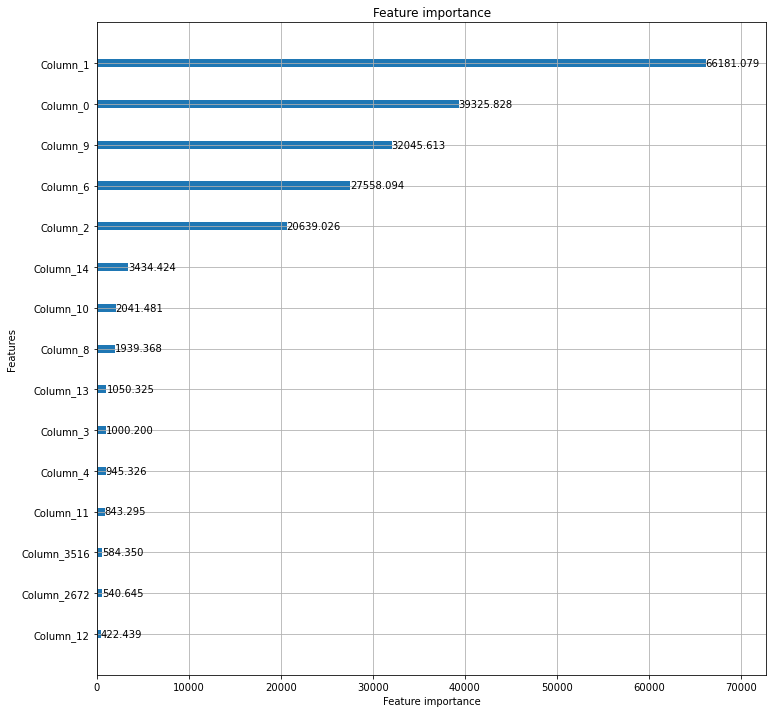

In [136]:
plot_importance(lgb_model, max_num_features = 15, figsize = (12,12))

In [137]:
features_names = flats.drop(columns=['product_name', 'address_name', 'lat', 'lon', 'description', 'coords', 'price']).columns.to_list() + ['total_square / rooms'] + list(tfidf_vec.get_feature_names_out())

In [138]:
best_features = [1, 0, 9, 6, 2, 14, 10, 8, 13, 3, 4, 11, 3516, 2672, 12]
for i in best_features:
    print(i, features_names[i])

1 total_square
0 postcode
9 street
6 district
2 rooms
14 total_square / rooms
10 distance_to_center
8 source
13 station_3
3 floor
4 city
11 station_1
3516 комплекс
2672 жк
12 station_2


Посмотрим на MAE, RMSE, R2 для валидационной и тестовой выборок. Видим, что MAE у них вообще очень близки, RMSE меньше у первой, а R2 у первой немного больше. Но возможно, это связано не с переобучением: так, максимальная цена квартиры в валидационной выборке оказалась примерно 600 млн., а максимальная цена на тесте - больше 1 млрд., поэтому возможно на разницу повлияло именно разбиение объектов.

In [139]:
print('Validation', end='\n\n')
print('RMSE:', mean_squared_error(y_val.values, np.e ** pred, squared=False))
print('MAE:', mean_absolute_error(y_val.values, np.e ** pred))
print('R2:', r2_score(y_val.values, np.e ** pred))

Validation

RMSE: 9250780.026913268
MAE: 2735383.1973703643
R2: 0.9272637357222323


In [140]:
print('Test', end='\n\n')
print('RMSE:', mean_squared_error(y_test.values, np.e ** lgb_model.predict(X_test), squared=False))
print('MAE:', mean_absolute_error(y_test.values, np.e ** lgb_model.predict(X_test)))
print('R2:', r2_score(y_test.values, np.e ** lgb_model.predict(X_test)))

Test

RMSE: 11903884.581271498
MAE: 2651089.6181910126
R2: 0.8986427673431415


In [176]:
%%time
explainer = shap.TreeExplainer(lgb_model, X_train.toarray())
shap_values = explainer.shap_values(X_test.toarray())

100%|===================| 14821/14824 [76:10<00:00]        

CPU times: total: 1h 16min 9s
Wall time: 1h 16min 33s


Попробуем другой подход к интерпретации результатов модели, с помощью shapley values. На картинке ниже видим, что важные признаки, по мнению данной модели, похожи на важные признаки для построения моделей, хотя здесь они идут немного в другом порядке. На этой картинке видим, например, что чем больше общая площадь квартиры, тем она дороже (много розовых точек в правой части, много синих - в левой). А расстояние до центра интерпретируется наоборот: чем меньше расстояние, тем дороже квартира, то же самое с расстояниями до метро. По этажам видим, что чем квартира выше, тем она дороже, а более низкий этаж влияет отрицательно на цену (возможно, особенно сильно влияет первый этаж). Попробуем проинтерпретировать некоторые переменные-слова. Наличие слова "дизайнерский" в объявлении положительно влияет на цену, здесь возможно речь идет о дизайнерском ремонте или интерьере в квартире. Наличие слова "апартамент" влияет отрицательно, возможно потому, что апартаменты действительно стоят, как правило, дешевле, чем обычные квартиры. Слово "собственник" влияет отрицательно, скорее всего, потому, что когда квартира продается без посредников, то ее продают немного дешевле из-за отсутствия необходимости оплаты дополнительных услуг. "Подземный" влияет положительно на цену, здесь наверно речь идет о подземном паркинге в доме, это дополнительное удобство, поэтому квартира стоит несколько дороже.

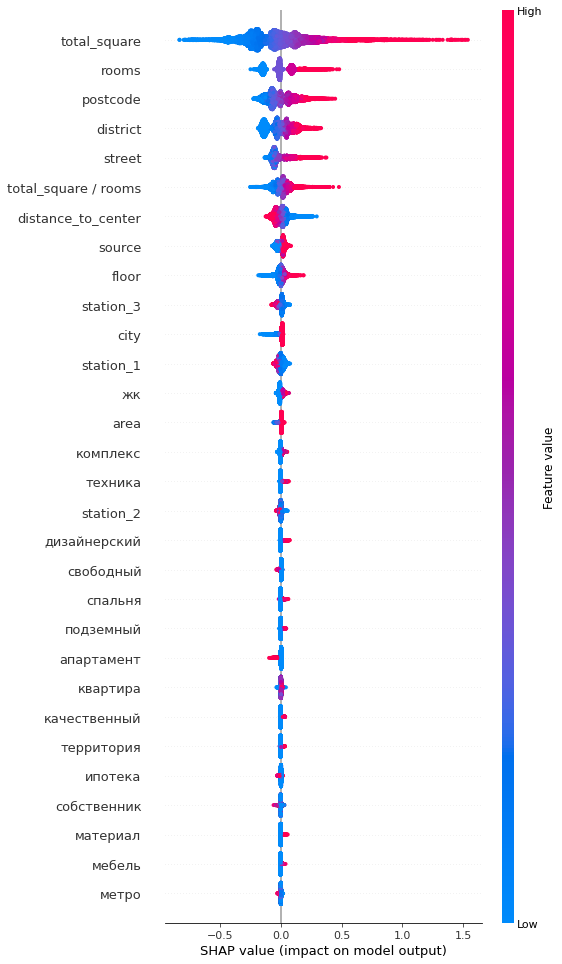

In [177]:
shap.summary_plot(shap_values, X_test.toarray(), max_display=30, feature_names=features_names)

Можно посмотреть на интерпретацию предсказаний для отдельных квартир. Квартира с индексом 157 из теста стоит несколько ниже среднего, на понижение ее стоимости повлияли следующие факторы: не очень удачные район и улица, большое расстояние до центра. И наоборот, факторы, повлиявшие положительно: площадь квартиры и количество комнат в ней. Суммарно учет всех факторов дал прогноз 16.36, при среднем значении по выборке в 16.67 (в логарифмах).

In [187]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[157], feature_names=features_names)

Посмотрим на более дорогую квартиру. Отрицательно на цену повлияли улица и этаж. Положительно - общая площадь, количество комнат, средняя площадь комнаты, почтовый индекс (то есть ее расположение), расстояние до центра.

In [188]:
shap.plots.force(explainer.expected_value, shap_values[429], feature_names=features_names)

Если расширить список переменных, то можно увидеть, что чуть менее важными оказались слова-признаки "школа", "кирпичный", "монолитный", "зеленый". Это наводит на мысль о том, что если дополнительно собрать информацию о доме, в котором расположена квартира (материал стен, год постройки, количество этажей в доме (и дополнительно определить крайний ли это этаж), высоту потолков) и об удаленности от квартиры таких объектов как больницы, школы, парки, то можно еще немного улучшить качество нашей итоговой модели.